<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_HR_gr2/blob/main/Abdrakhmanova%20Guzel/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Проект "Анализ резюме: Система HR-рекомендаций. (INSPECTRUM CLINIC)". Гузель Абдрахманова, 2-я группа стажировки (новички)**

**Цель: **
Разработать прототип системы, реализующей функцию рекомендательной системы для HR-специалиста.

**Принцип работы:**


1. Система должна помогать HR-специалисту вынести решение о том, подходит или не подходит человек на рассматриваемую должность.
2. В датасете целевым столбцом для предсказания является столбец под названием “Подходит - да/нет”.
3. Результатом работы обученной нейросети должно служить дополнение датасета столбцом под названием “оценка резюме”, где должно быть представлено процентное распределение вероятностей между классами “подходит” и “не подходит”. Например: "подходит 95% / не подходит 5%".
4. Система должна иметь возможность дообучаться на новых данных, предоставленных Заказчиком.

**Требования к тестированию, метрикам качества:**
Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%.



# **Первичное внешнее исследование датасета**

1) Датасет небольшой по размеру (579 анкет). Предполагаю, что его нужно будет расширять и дополнять.

2) Сам датасет скачивается файлом в формате xlsx. Так как с ним еще работают и он будет корректироваться, то предлагаю разместить его на гугл доках. Уровень доступа там можно корректировать.

3) Данные в датасете не структурированы и в некоторых случаях заполнены с явными ошибками:
- колонка "Дата отклика" есть даты 03.03.223 и 12.23.23
- колонка "ЗП" содержит суммы в разной валюте (рубли, USD, EUR, KZT, KGS, ...)
- на 8 вакансий всего 11 подходящих анкет (причем эти анкеты только для 4 вакансий)
- какие требования по 8 вакансиям непонятно
- колонку "Город" разделить на колонки с городом/страной и колонкой/ами по готовности к командировкам и командировкам
- у части анкет нет ответа в колонке "Подходит - да/нет"
- в таблице нет колонок "Ключевые навыки", "Обо мне" (в ТЗ они упоминаются)

4) Необходимы критерии по всем 8 вакансиям (нет описания самой вакансии)

5) Неравномерно соотношение по вакансиям данных да/нет по колонке Подходит да/нет: 11 положительных примеров (2%) против 489 отрицательных (98%) и еще 79 без метки да/нет

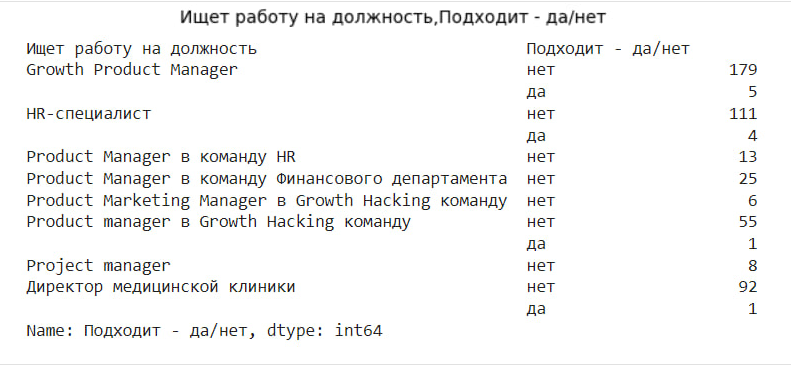

Вывод по первичному внешнему исследованию датасета: датасет несбалансирован, нейросеть на таких данных будет сложно обучить, возможно переобучение и/или запоминание правильных ответов. Что на реальных данных на практике даст плохие результаты по рекомендациям.
Выходом помимо предоставления заказчиком дополнительных данных по датасету будет выделение вакансий, по которым наибольшее количество да. И обучение по этим выделенным данным.


# **Загрузка датасета**

In [ ]:
# Загрузка файла датасета с диска в колаб

import gdown

!gdown 1gW8SkN6L73K1D7iB251fsyaOpBprBpll


Downloading...
From: https://drive.google.com/uc?id=1gW8SkN6L73K1D7iB251fsyaOpBprBpll
To: /content/dataset2.xlsx
100% 1.20M/1.20M [00:00<00:00, 72.0MB/s]


In [ ]:
import pandas as pd

import chardet

import datetime
import re
from tensorflow.keras import utils #Используем для to_categoricall

import tensorflow as tf

# Последовательная модель НС
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, concatenate, Input

# Слой задания активационной функции <----- !!!
from tensorflow.keras.layers import Activation

# Утилиты предобработки данных
from tensorflow.keras import utils

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Разделение на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split

# Рисование графиков
import matplotlib.pyplot as plt

import numpy as np # Библиотека работы с массивами

import requests
import json

from sklearn import metrics # Матрица ошибок

import seaborn as sns

In [ ]:
enc = chardet.detect(open("dataset2.xlsx", 'rb').read())

print(enc)

{'encoding': None, 'confidence': 0.0, 'language': None}


In [ ]:
data = pd.read_excel("dataset2.xlsx")
print(data.shape)
data.info()
data.head()

(579, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Unnamed: 0                                  579 non-null    int64 
 1   Дата отклика                                579 non-null    object
 2   Пол, возраст                                579 non-null    object
 3   ЗП                                          579 non-null    object
 4   Ищет работу на должность                    579 non-null    object
 5   Город                                       579 non-null    object
 6   Занятость                                   579 non-null    object
 7   График                                      579 non-null    object
 8   Опыт ()                                     579 non-null    object
 9   Последнее/нынешное место работы             579 non-null    object
 10  Последняя/нынешн

Unnamed: 0         Дата отклика                               Пол, возраст  \
0           0  2023-02-23 00:00:00                                    Женщина   
1           1  2023-01-11 00:00:00                                    Женщина   
2           2  2023-02-27 00:00:00  Мужчина, 33 года, родился 23 августа 1989   
3           3  2023-01-11 00:00:00   Мужчина, 32 года, родился 7 декабря 1990   
4           4  2023-01-11 00:00:00   Мужчина, 26 лет, родился 21 февраля 1996   

             ЗП Ищет работу на должность  \
0   90 000 руб.   Growth Product Manager   
1    не указана   Growth Product Manager   
2  150 000 руб.   Growth Product Manager   
3    не указана   Growth Product Manager   
4  150 000 руб.   Growth Product Manager   

                                               Город  \
0  Индонезия, Не готова к переезду, не готова к к...   
1  Москва, Готова к переезду, готова к командировкам   
2  Санкт-Петербург, Готов к переезду: Москва, гот...   
3  Москва, м. Молодежная, Хочу переехать, готов к...   
4       Пермь, Хочу переехать, готов к командировкам   

                                           Занятость  \
0  проектная работа, частичная занятость, полная ...   
1                                   полная занятость   
2  проектная работа, частичная занятость, полная ...   
3  стажировка, частичная занятость, полная занятость   
4  проектная работа, частичная занятость, полная ...   

                                         График  \
0                              удаленная работа   
1  удаленная работа, гибкий график, полный день   
2  удаленная работа, гибкий график, полный день   
3  удаленная работа, гибкий график, полный день   
4  удаленная работа, гибкий график, полный день   

                          Опыт ()  \
0   Опыт работы —5 лет 10 месяцев   
1  Опыт работы —11 лет 11 месяцев   
2     Опыт работы —7 лет 2 месяца   
3   Опыт работы —8 лет 10 месяцев   
4    Опыт работы —5 лет 9 месяцев   

                     Последнее/нынешное место работы  \
0                                PT MYBALI APP GROUP   
1                                      Банк Открытие   
2                                          DIKIY LLC   
3                                           WeInvest   
4  Индивидуальное предпринимательство / частная п...   

                  Последняя/нынешняя должность  \
0                         Менеджер по продукту   
1  Product owner трайб сбережения и инвестиции   
2                                                
3                Product Manager (team leader)   
4                      Product/Project manager   

          Выполняемые задачи на прошлых местах работ  \
0  Маркетинговые исследования\nИсследование рынка...   
1  Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...   
2  Запуск бренда и производства игристого кваса D...   
3  1. Исследование рынка\n2. Определение целевой ...   
4   Переговоры со стейкхолдером\n- Составление ТЗ...   

                                             Обо мне  \
0                                                NaN   
1                                                NaN   
2  Чем бы я ни занимался с 2014 года, когда решил...   
3  Я проактивный, коммуникабельный, позитивный, д...   
4  Набрал кучу опыта и хочу с ним найти классную ...   

                                     Ключевые навыки  \
0  Анализ рынка\nУправление проектами\nProduct Ma...   
1  Самомотивация\nТаймменеджмент\nКреативность\nЧ...   
2  Продвижение бренда\nПланирование маркетинговых...   
3  Управление проектами\nОрганизаторские навыки\n...   
4  Управление персоналом\nЗаключение договоров\nА...   

                                   Образование и ВУЗ        Обновление резюме  \
0  Высшее, 2023, Нетоло́гия, 2014, Университет Ро...  23 февраля 2023 в 16:30   
1  Высшее, 2022, GeekBrains, 2010, Московский худ...   8 февраля 2023 в 09:15   
2  Высшее, 2013, Санкт-Петербургский государствен...  28 февраля 2023 в 09:41   
3  Магистр, 2014, Московский государственный техн...   24 января 2023 в 12

Колонки "Обо мне", "Ключевые навыки" и "Подходит - да/нет" имеют пропуски, то есть колонки могут быть не заполнены.
В столбцах с текстовыми данными служебные символы видны (\n например)

# **Подготовка датасета к параметризации**

In [ ]:
#Удаляем лишнее
data.dropna(axis=0, how='any')
data.drop(["Unnamed: 0", "Дата отклика", "Обновление резюме"], axis=1, inplace=True)
data.fillna(0, inplace=True)
print(data.shape)

(579, 14)


In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Пол, возраст                                579 non-null    object
 1   ЗП                                          579 non-null    object
 2   Ищет работу на должность                    579 non-null    object
 3   Город                                       579 non-null    object
 4   Занятость                                   579 non-null    object
 5   График                                      579 non-null    object
 6   Опыт ()                                     579 non-null    object
 7   Последнее/нынешное место работы             579 non-null    object
 8   Последняя/нынешняя должность                579 non-null    object
 9   Выполняемые задачи на прошлых местах работ  579 non-null    object
 10  Обо мне                   

Пол, возраст            ЗП  \
0                                    Женщина   90 000 руб.   
1                                    Женщина    не указана   
2  Мужчина, 33 года, родился 23 августа 1989  150 000 руб.   
3   Мужчина, 32 года, родился 7 декабря 1990    не указана   
4   Мужчина, 26 лет, родился 21 февраля 1996  150 000 руб.   

  Ищет работу на должность                                              Город  \
0   Growth Product Manager  Индонезия, Не готова к переезду, не готова к к...   
1   Growth Product Manager  Москва, Готова к переезду, готова к командировкам   
2   Growth Product Manager  Санкт-Петербург, Готов к переезду: Москва, гот...   
3   Growth Product Manager  Москва, м. Молодежная, Хочу переехать, готов к...   
4   Growth Product Manager       Пермь, Хочу переехать, готов к командировкам   

                                           Занятость  \
0  проектная работа, частичная занятость, полная ...   
1                                   полная занятость   
2  проектная работа, частичная занятость, полная ...   
3  стажировка, частичная занятость, полная занятость   
4  проектная работа, частичная занятость, полная ...   

                                         График  \
0                              удаленная работа   
1  удаленная работа, гибкий график, полный день   
2  удаленная работа, гибкий график, полный день   
3  удаленная работа, гибкий график, полный день   
4  удаленная работа, гибкий график, полный день   

                          Опыт ()  \
0   Опыт работы —5 лет 10 месяцев   
1  Опыт работы —11 лет 11 месяцев   
2     Опыт работы —7 лет 2 месяца   
3   Опыт работы —8 лет 10 месяцев   
4    Опыт работы —5 лет 9 месяцев   

                     Последнее/нынешное место работы  \
0                                PT MYBALI APP GROUP   
1                                      Банк Открытие   
2                                          DIKIY LLC   
3                                           WeInvest   
4  Индивидуальное предпринимательство / частная п...   

                  Последняя/нынешняя должность  \
0                         Менеджер по продукту   
1  Product owner трайб сбережения и инвестиции   
2                                                
3                Product Manager (team leader)   
4                      Product/Project manager   

          Выполняемые задачи на прошлых местах работ  \
0  Маркетинговые исследования\nИсследование рынка...   
1  Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...   
2  Запуск бренда и производства игристого кваса D...   
3  1. Исследование рынка\n2. Определение целевой ...   
4   Переговоры со стейкхолдером\n- Составление ТЗ...   

                                             Обо мне  \
0                                                  0   
1                                                  0   
2  Чем бы я ни занимался с 2014 года, когда решил...   
3  Я проактивный, коммуникабельный, позитивный, д...   
4  Набрал кучу опыта и хочу с ним найти классную ...   

                                     Ключевые навыки  \
0  Анализ рынка\nУправление проектами\nProduct Ma...   
1  Самомотивация\nТаймменеджмент\nКреативность\nЧ...   
2  Продвижение бренда\nПланирование маркетинговых...   
3  Управление проектами\nОрганизаторские навыки\n...   
4  Управление персоналом\nЗаключение договоров\nА...   

                                   Образование и ВУЗ Подходит - да/нет  
0  Высшее, 2023, Нетоло́гия, 2014, Университет Ро...                да  
1  Высшее, 2022, GeekBrains, 2010, Московский худ...                да  
2  Высшее, 2013, Санкт-Петербургский государствен...                да  
3  Магистр, 2014, Московский государственный техн...                да  
4  Высшее, 2021, Российская академия народного хо...                да

In [ ]:
# Убираем кодировку ASCII (\xa0 - неразрывный пробел, \n - перенос строки) в текстовых строках
for i in range(data.shape[1]):
  for j in range(data.shape[0]):
    if isinstance(data.values[j][i], (int, float)) == False:
       data.values[j][i] = data.values[j][i].replace("\xa0", " ")
       data.values[j][i] = data.values[j][i].replace("\n", ". ")

data.head()

Пол, возраст            ЗП  \
0                                    Женщина   90 000 руб.   
1                                    Женщина    не указана   
2  Мужчина, 33 года, родился 23 августа 1989  150 000 руб.   
3   Мужчина, 32 года, родился 7 декабря 1990    не указана   
4   Мужчина, 26 лет, родился 21 февраля 1996  150 000 руб.   

  Ищет работу на должность                                              Город  \
0   Growth Product Manager  Индонезия, Не готова к переезду, не готова к к...   
1   Growth Product Manager  Москва, Готова к переезду, готова к командировкам   
2   Growth Product Manager  Санкт-Петербург, Готов к переезду: Москва, гот...   
3   Growth Product Manager  Москва, м. Молодежная, Хочу переехать, готов к...   
4   Growth Product Manager       Пермь, Хочу переехать, готов к командировкам   

                                           Занятость  \
0  проектная работа, частичная занятость, полная ...   
1                                   полная занятость   
2  проектная работа, частичная занятость, полная ...   
3  стажировка, частичная занятость, полная занятость   
4  проектная работа, частичная занятость, полная ...   

                                         График  \
0                              удаленная работа   
1  удаленная работа, гибкий график, полный день   
2  удаленная работа, гибкий график, полный день   
3  удаленная работа, гибкий график, полный день   
4  удаленная работа, гибкий график, полный день   

                          Опыт ()  \
0   Опыт работы —5 лет 10 месяцев   
1  Опыт работы —11 лет 11 месяцев   
2     Опыт работы —7 лет 2 месяца   
3   Опыт работы —8 лет 10 месяцев   
4    Опыт работы —5 лет 9 месяцев   

                     Последнее/нынешное место работы  \
0                                PT MYBALI APP GROUP   
1                                      Банк Открытие   
2                                          DIKIY LLC   
3                                           WeInvest   
4  Индивидуальное предпринимательство / частная п...   

                  Последняя/нынешняя должность  \
0                         Менеджер по продукту   
1  Product owner трайб сбережения и инвестиции   
2                                                
3                Product Manager (team leader)   
4                      Product/Project manager   

          Выполняемые задачи на прошлых местах работ  \
0  Маркетинговые исследования. Исследование рынка...   
1  Участие в команде роста. В2В. . Задачи:. - Раз...   
2  Запуск бренда и производства игристого кваса D...   
3  1. Исследование рынка. 2. Определение целевой ...   
4   Переговоры со стейкхолдером. - Составление ТЗ...   

                                             Обо мне  \
0                                                  0   
1                                                  0   
2  Чем бы я ни занимался с 2014 года, когда решил...   
3  Я проактивный, коммуникабельный, позитивный, д...   
4  Набрал кучу опыта и хочу с ним найти классную ...   

                                     Ключевые навыки  \
0  Анализ рынка. Управление проектами. Product Ma...   
1  Самомотивация. Таймменеджмент. Креативность. Ч...   
2  Продвижение бренда. Планирование маркетинговых...   
3  Управление проектами. Организаторские навыки. ...   
4  Управление персоналом. Заключение договоров. А...   

                                   Образование и ВУЗ Подходит - да/нет  
0  Высшее, 2023, Нетоло́гия, 2014, Университет Ро...                да  
1  Высшее, 2022, GeekBrains, 2010, Московский худ...                да  
2  Высшее, 2013, Санкт-Петербургский государствен...                да  
3  Магистр, 2014, Московский государственный техн...                да  
4  Высшее, 2021, Российская академия народного хо...                да

# **Параметризация датасета**

In [ ]:
# Копию делаем. Бекапы - это обязательно.
data2 = data.copy()


**Пол** 0/1 (1 - мужчина, 0 - женщина)

**Возраст** **ОНЕ на 8** (не указан - 0, от 1 до 17, от 18 до 24, от 25 до 35, от 36 до 44, от 45 до 59, от 60 до 74, от 75 и старше)  [0 0 0 0 0 1 0 0] (в колонке "Пол, возраст", *возраст может быть не указан*)

**ЗП** **ОНЕ на 8** (не указан или 1, от 2 до 20000, от 20001 до 30000, от 30001 до 50000, от 50001 до 80000, от 80001 до 150000, от 150001 до 300000, от 300001 и выше) (переводить валюту в рубли) [0 0 0 0 0 1 0 0]  (*может быть не указана*)

**Ищет должность OHE на 8** (Growth Product Manager, HR-специалист, Product manager в Growth Hacking команду, Product Manager в команду HR, Product Manager в команду Финансового департамента, Product Marketing Manager в Growth Hacking команду, Project manager, Директор медицинской клиники) [0 0 0 0 0 1 0 0]

**Город** **ОНЕ на 5** (Москва, Санкт-Петербург, Уфа, города-миллионники(Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Красноярск Пермь Воронеж Волгоград), все остальные страны и города) [0 0 1 0 0]

**Готовность к переезду, командировкам Multi(2x)** (готова к переезду/готов к переезду, готова к командировкам/готов к командировкам) (в колонке "Город", может быть не указан)

**Занятость Multi(6x)** (стажировка, волонтерство, проектная работа, частичная занятость, неполный рабочий день, полная занятость)

**График Multi(5x)** (вахтовый метод, удаленная работа, гибкий график, полный день, сменный график)

**Опыт ОНЕ на 11** [0 0 0 0 0 1 0 0 0 0 0] (0 - 6 месяцев, 7 - 12 месяцев, 13 - 24 месяцев, 25 - 36 месяцев, 37 - 60 месяцев, 61 - 96 месяцев, 97 - 120 месяцев, 121 - 156 месяцев, 157 - 192 месяцев, 193 - 240 месяцев, больше 240 месяцев)

**Образование и ВУЗ ОНЕ на 10** [0 0 0 0 0 1 0 0 0 0] (Бакалавр;Высшее;Среднее специальное;Неоконченное высшее;Среднее;Среднее образование;Доктор наук;
Кандидат наук;Магистр;нет образования)

**Подходит** 0/1 (1 - да, 0 - нет)

Все остальные текстовые данные из колонок (**Последнее/нынешное место работы, Последняя/нынешняя должность, Выполняемые задачи на прошлых местах работ, Обо мне, Ключевые навыки**) объединяются для токенизации.

## Пол и возраст

In [ ]:
# Функции для пола и возраста
def func_gender(arg):
  if "M" in arg:
    return 1
  else:
    return 0

def func_age(arg):
  phrase_split = arg.split(",")
  if len(phrase_split) > 1:
    year = int(re.findall(r'\d+', phrase_split[1])[0])
  else:
    year = 0
  return year

# Функция определения категории возраста
def func_age_ohe(arg):
  out = func_age(arg)
  if out == 0:
    age_vector = 0
  elif 1 <= out <= 17:
    age_vector = 1
  elif 18 <= out <= 24:
    age_vector = 2
  elif 25 <= out <= 35:
    age_vector = 3
  elif 36 <= out <= 44:
    age_vector = 4
  elif 45 <= out <= 59:
    age_vector = 5
  elif 60 <= out <= 74:
    age_vector = 6
  else:
    age_vector = 7

  return list(utils.to_categorical(age_vector, 8).astype('int'))


## Зарплата

In [ ]:
# Зарплата
def func_salary(arg):
  num = arg

  if (type(num) == str):
    if num == "не указана":
      num = 1
      curr = "руб"
    else:
      # Убираем цифры, получаем в какой валюте
      curr = re.sub('[0-9]','',arg)
      curr = curr.replace('.','').strip()

      # Убираем лишние знаки, получаем число
      num = re.sub(' ','',num)
      num = re.sub('[а-яА-ЯёЁ]','',num)
      num = re.sub('[a-zA-Z]','',num)
      num = num.replace('.','')

      if curr == 'грн':
        curr = 'UAH'
      elif curr == 'белруб':
        curr = 'BYN'
      elif curr == 'сум':
        curr = 'UZS'

    # Конвертируем в рубли, если валюта
    if curr != "руб":
      text = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').text # запрос данных по валютам
      all_value = json.loads(text)
      value_num = all_value["Valute"][curr]["Value"]
      nominal = all_value["Valute"][curr]["Nominal"]
      if value_num != "":
        try:
          num = value_num / nominal * float(num)
        except KeyError:
          curr = "руб"
      else:
        curr = "руб"

  salary = int(num)

  return salary

# Функция определения категории зарплаты
def func_salary_ohe(arg):
  if arg == 1:
    salary_vector = 0
  elif 2 <= arg <= 20000:
    salary_vector = 1
  elif 20001 <= arg <= 30000:
    salary_vector = 2
  elif 30001 <= arg <= 50000:
    salary_vector = 3
  elif 50001 <= arg <= 80000:
    salary_vector = 4
  elif 80001 <= arg <= 150000:
    salary_vector = 5
  elif 150001 <= arg <= 300000:
    salary_vector = 6
  else:
    salary_vector = 7

  return list(utils.to_categorical(salary_vector, 8).astype('int'))

## Должность, Город, Переезд и командировки, Занятость, График работы, Образование

In [ ]:
# Должность
def func_vacancy(arg):
  if arg == "Growth Product Manager":
    vacancy_vector = 0
  elif arg == "HR-специалист":
    vacancy_vector = 1
  elif arg == "Product manager в Growth Hacking команду":
    vacancy_vector = 2
  elif arg == "Product Manager в команду HR":
    vacancy_vector = 3
  elif arg == "Product Manager в команду Финансового департамента":
    vacancy_vector = 4
  elif arg == "Product Marketing Manager в Growth Hacking команду":
    vacancy_vector = 5
  elif arg == "Project manager":
    vacancy_vector = 6
  elif arg == "Директор медицинской клиники":
    vacancy_vector = 7
  else:
    vacancy_vector = 2

  return list(utils.to_categorical(vacancy_vector, 8).astype('int'))

# Город
def func_city(arg):
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Красноярск Пермь Воронеж Волгоград"
  sarg=arg.split(',')
  for item in sarg:
    item= item.strip()
    if item == "Москва":          return [1, 0, 0, 0, 0]
    if item == "Санкт-Петербург": return [0, 1, 0, 0, 0]
    if item == "Уфа":             return [0, 0, 1, 0, 0]
    if item in millionCities:     return [0, 0, 0, 1, 0]
  return [0, 0, 0, 0, 1]

# Переезд и командировки
def func_relocation(arg):
  sarg=arg.lower()
  out= [0, 0]
  if ("готова к переезду" or "готов к переезду" or "хочу переехать" in arg):     out[0]=1
  if ("готова к командировкам" or "готов к командировкам" in arg):               out[1]=1
  return out

# Занятость
def func_employment(arg):
  out= [0, 0, 0, 0, 0, 0]
  if ("стажировка" in arg):             out[0]=1
  if ("волонтерство" in arg):           out[1]=1
  if ("проектная работа" in arg):       out[2]=1
  if ("частичная занятость" in arg):    out[3]=1
  if ("неполный рабочий день" in arg):  out[4]=1
  if ("полная занятость" in arg):       out[5]=1
  return out

# График работы
def func_working_schedule(arg):
  out = [0, 0, 0, 0, 0]
  if ("вахтовый метод" in arg):    out[0]=1
  if ("удаленная работа" in arg):  out[1]=1
  if ("гибкий график" in arg):     out[2]=1
  if ("полный день" in arg):       out[3]=1
  if ("сменный график" in arg):    out[4]=1
  return out

# Данные об образовании
def func_education(arg):
  out = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #По умолчанию не указано
  if "Бакалавр" in arg:             out[0] = 1
  elif "Высшее" in arg:               out[1] = 1
  elif "Среднее специальное" in arg:  out[2] = 1
  elif "Неоконченное высшее" in arg:  out[3] = 1
  elif "Среднее" in arg:              out[4] = 1
  elif "Среднее образование" in arg:  out[5] = 1
  elif "Доктор наук" in arg:          out[6] = 1
  elif "Кандидат наук" in arg:        out[7] = 1
  elif "Магистр" in arg:              out[8] = 1
  else: out[9] = 1
  return out


## Опыт работы



In [ ]:
# Данные об опыте работы
def func_work_experience(arg):
  arg = arg.replace("—", '')
  month_key = ['месяц', 'месяцев', 'месяца']
  year_key = ['год', 'лет', 'года']

  if arg == 'Не указано' or pd.isnull(arg):
    return 0

  args_split = arg.split(' ')[:6]
  month = 0
  year = 0
  for i in range(len(args_split)):
      if args_split[i] in month_key:
           month = args_split[i-1]
      if args_split[i] in year_key:
          year = args_split[i-1]
  return abs(int(year))*12 + abs(int(month))

# Категориальное представление опыта работы
def func_work_experience_vector(arg):
  out = func_work_experience(arg)
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9
  if (out > 240): # если больше 240 месяцев
    outClass = 10

  return list(utils.to_categorical(outClass, 11).astype('int'))

## Подходит (да/нет)

In [ ]:
def func_final_result(arg):
  if arg == 'да' or arg == 'Да':
    return 1
  else:
    return 0

## Обработка текстовых данных

In [ ]:
print(data2.values)

[['Женщина' '90 000 руб.' 'Growth Product Manager' ...
  'Анализ рынка. Управление проектами. Product Management. Проведение презентаций. Навыки продаж. Декомпозици. Вывод продукта на рынок. Custbev'
  'Высшее, 2023, Нетоло́гия, 2014, Университет Российской академии образования, Москва'
  'да']
 ['Женщина' 'не указана' 'Growth Product Manager' ...
  'Самомотивация. Таймменеджмент. Креативность. Чувство юмора. Adobe Photoshop. Adobe Illustrator. Adobe InDesign. Figma. Trello. Многозадачность. Аналитическое мышление'
  'Высшее, 2022, GeekBrains, 2010, Московский художественно-промышленный институт, Москва'
  'да']
 ['Мужчина, 33 года, родился 23 августа 1989' '150 000 руб.'
  'Growth Product Manager' ...
  'Продвижение бренда. Планирование маркетинговых кампаний. Маркетинговые исследования. Управление проектами. Управление командой. Стратегический маркетинг. Ценовая политика. Клиентоориентированность. Бренд-менеджмент. Запуск нового бренда. Позиционирование бренда'
  'Высшее, 2013, Санкт

In [ ]:
print(len(data2.values))
print(data2.values[0])

579
['Женщина' '90 000 руб.' 'Growth Product Manager'
 'Индонезия, Не готова к переезду, не готова к командировкам'
 'проектная работа, частичная занятость, полная занятость'
 'удаленная работа' 'Опыт работы —5 лет 10 месяцев' 'PT MYBALI APP GROUP'
 'Менеджер по продукту'
 'Маркетинговые исследования. Исследование рынка; Исследование конкурентов; Исследование потребителей; Планирование рекламы.. Виды исследований: Опросы; Фокус-группы; Глубинные интервью; Эксперименты, полевые исследования.. Задачи в рамках исследования потребителей: Анализ потребительских трендов; Анализ обратной связи от клиентов; Сегментация аудитории; Составление портрета целевой аудитории.. Реклама у лидеров мнений. Организация и контроль взаимодействия с лидерами мнений (селебрити, блогеры).. Опыт организации коллабораций.. SMM и комьюнити-менеджмент. Планирование продвижения; Создание и контроль контента; Наполнение аккаунтов, сообществ; Модерирование и развитие аккаунтов, сообществ.. Социальные сети: Telegram..

In [ ]:
# Обработка текстовых данных
def func_text(df, list_vacancies=["Growth Product Manager", "HR-специалист", "Product manager в Growth Hacking команду",
                                      "Product Manager в команду HR", "Product Manager в команду Финансового департамента",
                                      "Product Marketing Manager в Growth Hacking команду", "Project manager", "Директор медицинской клиники"]):
  spisok = []

  for i in range(len(df)):
    spisok_text = ""
    for val in range(len(df[i])):
      if df[i][2] in list_vacancies and df[i][val] != 0 and (val == 7 or val == 8 or val == 9 or val == 10 or val == 11):
        spisok_text += df[i][val] + ". "
    if df[i][2] in list_vacancies:
      spisok.append(spisok_text)
    else:
      spisok_text = ""
  print(len(spisok))
  spisok = np.array(spisok)

  return spisok

# Вытаскиваются текстовые данные и выводится пример
spisok_words = func_text(data2.values)
print(spisok_words[0])

579
PT MYBALI APP GROUP. Менеджер по продукту. Маркетинговые исследования. Исследование рынка; Исследование конкурентов; Исследование потребителей; Планирование рекламы.. Виды исследований: Опросы; Фокус-группы; Глубинные интервью; Эксперименты, полевые исследования.. Задачи в рамках исследования потребителей: Анализ потребительских трендов; Анализ обратной связи от клиентов; Сегментация аудитории; Составление портрета целевой аудитории.. Реклама у лидеров мнений. Организация и контроль взаимодействия с лидерами мнений (селебрити, блогеры).. Опыт организации коллабораций.. SMM и комьюнити-менеджмент. Планирование продвижения; Создание и контроль контента; Наполнение аккаунтов, сообществ; Модерирование и развитие аккаунтов, сообществ.. Социальные сети: Telegram.. Прямая реклама. Разработка программ лояльности.Составление и тестирование гипотез. Анализ конкурентов. Изучение потребностей потребителя ( касдев, проведения интервью) CJM Работа с UX/UR Визуализация данных. Бизнесмодель. Токон

In [ ]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса

#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 10000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(spisok_words) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра

In [ ]:
print(tokenizer)
print(items)


[('unknown', 1), ('и', 2), ('в', 3), ('с', 4), ('по', 5), ('на', 6), ('для', 7), ('работа', 8), ('разработка', 9), ('управление', 10), ('контроль', 11), ('•', 12), ('анализ', 13), ('работы', 14), ('проведение', 15), ('компании', 16), ('ведение', 17), ('организация', 18), ('продаж', 19), ('продукта', 20), ('за', 21), ('2', 22), ('бизнес', 23), ('персонала', 24), ('1', 25), ('составление', 26), ('клиентов', 27), ('3', 28), ('подготовка', 29), ('новых', 30), ('создание', 31), ('формирование', 32), ('обучение', 33), ('к', 34), ('до', 35), ('планирование', 36), ('продуктов', 37), ('от', 38), ('проектов', 39), ('сотрудников', 40), ('задач', 41), ('поиск', 42), ('5', 43), ('отдела', 44), ('4', 45), ('проекта', 46), ('участие', 47), ('командой', 48), ('рынка', 49), ('договоров', 50), ('их', 51), ('опыт', 52), ('навыки', 53), ('подбор', 54), ('product', 55), ('процессов', 56), ('взаимодействие', 57), ('деятельности', 58), ('мероприятий', 59), ('интернет', 60), ('разработки', 61), ('проектами', 

In [ ]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
spisok_words_indexes = tokenizer.texts_to_sequences(spisok_words) #обучающие тесты в индексы

In [ ]:
n = 0
print(spisok_words[n])       # Все текстовые поля по 1 человеку
print(spisok_words_indexes[n]) # Все текстовые поля по 1 человеку через индексы


PT MYBALI APP GROUP. Менеджер по продукту. Маркетинговые исследования. Исследование рынка; Исследование конкурентов; Исследование потребителей; Планирование рекламы.. Виды исследований: Опросы; Фокус-группы; Глубинные интервью; Эксперименты, полевые исследования.. Задачи в рамках исследования потребителей: Анализ потребительских трендов; Анализ обратной связи от клиентов; Сегментация аудитории; Составление портрета целевой аудитории.. Реклама у лидеров мнений. Организация и контроль взаимодействия с лидерами мнений (селебрити, блогеры).. Опыт организации коллабораций.. SMM и комьюнити-менеджмент. Планирование продвижения; Создание и контроль контента; Наполнение аккаунтов, сообществ; Модерирование и развитие аккаунтов, сообществ.. Социальные сети: Telegram.. Прямая реклама. Разработка программ лояльности.Составление и тестирование гипотез. Анализ конкурентов. Изучение потребностей потребителя ( касдев, проведения интервью) CJM Работа с UX/UR Визуализация данных. Бизнесмодель. Токономик

In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain_text = tokenizer.sequences_to_matrix(spisok_words_indexes) # Подаем в виде списка чтобы метод успешно сработал
print(xTrain_text.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain_text[0][0:100])

(579, 10000)
[0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


# **Подготовка выборок для подачи в НС**

In [ ]:
# Извлекаем все параметры
def getAllParameters(val):
  gender = func_gender(val[0])  #параметры о поле
  age = func_age_ohe(val[0]) #параметры о возрасте
  salary = func_salary_ohe(func_salary(val[1])) #параметры о зарплате
  vacancy = func_vacancy(val[2]) #параметры о должности
  city = func_city(val[3]) #параметры о городе
  relocation = func_relocation(val[3]) #параметры о переездах и командировках
  employment = func_employment(val[4]) #параметры о желаемой занятости
  shedule = func_working_schedule(val[5]) #параметры о желаемом графике
  work_experience = func_work_experience_vector(val[6]) #параметры об опыте
  education = func_education(val[12]) #параметры об образовании
  out = []

# Склеиваем все параметры в вектор
  out.append(gender)
  out += age
  out += salary
  out += vacancy
  out += city
  out += relocation
  out += employment
  out += shedule
  out += work_experience
  out += education

  return out


In [ ]:
print(getAllParameters(data2.values[0]))


[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Создаем тренировочную выборку
def training_sample(values, list_vacancies=["Growth Product Manager", "HR-специалист", "Product manager в Growth Hacking команду",
                                                 "Product Manager в команду HR", "Product Manager в команду Финансового департамента",
                                                 "Product Marketing Manager в Growth Hacking команду", "Project manager", "Директор медицинской клиники"]):
  xTrain = []
  yTrain = []

  for val in range(len(values)):
    cell_value = values[val][2]
    if cell_value in list_vacancies:
      x = getAllParameters(values[val])
      y = func_final_result(values[val][13])

      xTrain.append(x)
      yTrain.append(y)

  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)

  return (xTrain, yTrain)


In [ ]:
(xTrain, yTrain) = training_sample(data2.values) # Извлекаем значения загруженного набора данных

print('xTrain, yTrain:', xTrain.shape, yTrain.shape)

x_train, x_test, y_train, y_test = train_test_split(xTrain, yTrain, test_size=0.2) # Делим на тренировочную и тестовую выборку
#Выводим результирующие размеры таблиц
print('Train:', x_train.shape, y_train.shape)
print('Test:', x_test.shape, y_test.shape)

# Пример обработанных данных
n = 0
print(x_train[n])
print(y_train[n])

xTrain, yTrain: (579, 64) (579,)
Train: (463, 64) (463,)
Test: (116, 64) (116,)
[0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
0


In [ ]:
n = 15
print(x_train[n])
print(y_train[n])

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
0


In [ ]:
print(sum(y_train) + sum(y_test))


11


In [ ]:
x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(xTrain_text, yTrain, test_size=0.2) # Делим на тренировочную и тестовую выборку для текстовых данных
#Выводим результирующие размеры таблиц
print('Train:', x_train_text.shape, y_train_text.shape)
print('Test:', x_test_text.shape, y_test_text.shape)

# Пример обработанных данных
n = 0
print(x_train_text[n])
print(y_train_text[n])

Train: (463, 10000) (463,)
Test: (116, 10000) (116,)
[0. 1. 1. ... 0. 0. 0.]
0


# **Создание НС**

## Функции для НС

In [ ]:
def func_create_model(relevance=""):

  # Создание модели
  model = Sequential()

  # Добавление слоев
  if relevance == "text":
    model.add(Dense(20, input_dim=x_train_text.shape[1], activation='relu'))
  elif relevance == "test":
    model.add(Dense(20, input_dim=x_train_test.shape[1], activation='relu'))
  elif relevance == "test_text":
    model.add(Dense(20, input_dim=x_train_test_text.shape[1], activation='relu'))
  else:
    model.add(Dense(20, input_dim=x_train.shape[1], activation='relu'))

  model.add(Dense(20))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, activation='sigmoid'))

  # Компиляция и возврат модели
  model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

  return model


def func_fit_model(model, relevance=""):

  # Обучение нейронной сети
  if relevance == "text":
    history = model.fit(x_train_text,
                        y_train_text,
                        batch_size=20,
                        epochs=80,
                        validation_split=0.2,
                        verbose=1)
  elif relevance == "test":
    history = model.fit(x_train_test,    # Обучающая выборка параметров
        y_train_test,               # Обучающая выборка меток класса
        batch_size=8,          # Размер батча (пакета)
        epochs=80,            # Количество эпох обучения
        validation_split=0.2,  # Доля проверочной выборки
        verbose=1)             # Отображение хода обучения
  elif relevance == "test_text":
    history = model.fit(x_train_test_text,    # Обучающая выборка параметров
        y_train_test_text,               # Обучающая выборка меток класса
        batch_size=8,          # Размер батча (пакета)
        epochs=80,            # Количество эпох обучения
        validation_split=0.2,  # Доля проверочной выборки
        verbose=1)             # Отображение хода обучения
  else:
    history = model.fit(x_train,    # Обучающая выборка параметров
        y_train,               # Обучающая выборка меток класса
        batch_size=8,          # Размер батча (пакета)
        epochs=80,            # Количество эпох обучения
        validation_split=0.2,  # Доля проверочной выборки
        verbose=1)             # Отображение хода обучения

  return history


In [ ]:
# Построение графиков

def func_plot(arg):
  plt.figure(figsize = (20,5))

  plt.subplot(1,2,1)
  plt.plot(arg.history['loss'], label = 'Значение ошибки на обучающей выборке')
  plt.plot(arg.history['val_loss'], label = 'Значение ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = "major", color = "black", alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = "minor", color = "gray", linestyle = "--", alpha = 0.3)

  plt.subplot(1,2,2)
  plt.plot(arg.history['accuracy'], label = 'Доля верных ответов на обучающей выборке')
  plt.plot(arg.history['val_accuracy'], label = 'Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = "major", color = "black", alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = "minor", color = "gray", linestyle = "--", alpha = 0.3)

  plt.show()


In [ ]:
# Проверка на тестовых данных

def func_evaluate(model, relevance=""):

  if relevance == "text":
    scores = model.evaluate(x_test_text,
                          y_test_text,
                          verbose=1
                          )
  elif relevance == "test":
    scores = model.evaluate(x_test_test,
                          y_test_test,
                          verbose=1
                          )
  elif relevance == "test_text":
    scores = model.evaluate(x_test_test_text,
                          y_test_test_text,
                          verbose=1
                          )
  else:
    scores = model.evaluate(x_test,
                          y_test,
                          verbose=1
                          )

  print("Процент верных ответов на тестовых данных:", round(scores[1], 2) * 100, "%")


In [ ]:
# Вывод результатов оценки работы модели на тестовых данных

def func_predict(model, relevance=""):

  # Вычисление предсказания сети
  if relevance == "text":
    y_predict_train = model.predict(x_train_text)
    y_predict_test = model.predict(x_test_text)
  elif relevance == "test":
    y_predict_train = model.predict(x_train_test)
    y_predict_test = model.predict(x_test_test)
  elif relevance == "test_text":
    y_predict_train = model.predict(x_train_test_text)
    y_predict_test = model.predict(x_test_test_text)
  else:
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)

  # Матрица ошибок классификатора
  if relevance == "text":
    confusion_matrix_train = metrics.confusion_matrix(y_train_text, y_predict_train.round())
    confusion_matrix_test = metrics.confusion_matrix(y_test_text, y_predict_test.round())
  elif relevance == "test":
    confusion_matrix_train = metrics.confusion_matrix(y_train_test, y_predict_train.round())
    confusion_matrix_test = metrics.confusion_matrix(y_test_test, y_predict_test.round())
  elif relevance == "test_text":
    confusion_matrix_train = metrics.confusion_matrix(y_train_test_text, y_predict_train.round())
    confusion_matrix_test = metrics.confusion_matrix(y_test_test_text, y_predict_test.round())
  else:
    confusion_matrix_train = metrics.confusion_matrix(y_train, y_predict_train.round())
    confusion_matrix_test = metrics.confusion_matrix(y_test, y_predict_test.round())

  # Отрисовка матрицы ошибок
  fig, axes = plt.subplots(1, 2, figsize = (15, 10)) # фигура + 2 координатные плоскости

  # Тепловая карта для первой матрицы ошибок
  sns.heatmap(confusion_matrix_train, annot = True, fmt = '', ax = axes[0], cmap = 'Blues')
  axes[1].set_title('confusion_matrix_train')
  axes[1].set_xlabel('y_prediction')
  axes[1].set_ylabel('y_true')

  # Тепловая карта для второй матрицы ошибок
  sns.heatmap(confusion_matrix_test, annot = True, fmt = '', ax = axes[1], cmap = 'Blues')
  axes[0].set_title('confusion_matrix_test')
  axes[0].set_xlabel('y_prediction')
  axes[0].set_ylabel('y_true')

  # Вывод текстом

  if relevance == "text":
    print(f'Accuracy: {metrics.accuracy_score(y_train_text, y_predict_train.round()):.2f}')
    #Рассчет precision
    print(f'Precision: {metrics.precision_score(y_train_text, y_predict_train.round()):.2f}')
    #Рассчет recall
    print(f'Recall: {metrics.recall_score(y_train_text, y_predict_train.round()):.2f}')
    #Рассчет F1
    print(f'F1 score: {metrics.f1_score(y_train_text, y_predict_train.round()):.2f}')

    print(f'Accuracy: {metrics.accuracy_score(y_test_text, y_predict_test.round()):.2f}')
    print(f'Precision: {metrics.precision_score(y_test_text, y_predict_test.round()):.2f}')
    print(f'Recall: {metrics.recall_score(y_test_text, y_predict_test.round()):.2f}')
    print(f'F1 score: {metrics.f1_score(y_test_text, y_predict_test.round()):.2f}')
  elif relevance == "test":
    print(f'Accuracy: {metrics.accuracy_score(y_train_test, y_predict_train.round()):.2f}')
    #Рассчет precision
    print(f'Precision: {metrics.precision_score(y_train_test, y_predict_train.round()):.2f}')
    #Рассчет recall
    print(f'Recall: {metrics.recall_score(y_train_test, y_predict_train.round()):.2f}')
    #Рассчет F1
    print(f'F1 score: {metrics.f1_score(y_train_test, y_predict_train.round()):.2f}')

    print(f'Accuracy: {metrics.accuracy_score(y_test_test, y_predict_test.round()):.2f}')
    print(f'Precision: {metrics.precision_score(y_test_test, y_predict_test.round()):.2f}')
    print(f'Recall: {metrics.recall_score(y_test_test, y_predict_test.round()):.2f}')
    print(f'F1 score: {metrics.f1_score(y_test_test, y_predict_test.round()):.2f}')
  elif relevance == "test_text":
    print(f'Accuracy: {metrics.accuracy_score(y_train_test_text, y_predict_train.round()):.2f}')
    #Рассчет precision
    print(f'Precision: {metrics.precision_score(y_train_test_text, y_predict_train.round()):.2f}')
    #Рассчет recall
    print(f'Recall: {metrics.recall_score(y_train_test_text, y_predict_train.round()):.2f}')
    #Рассчет F1
    print(f'F1 score: {metrics.f1_score(y_train_test_text, y_predict_train.round()):.2f}')

    print(f'Accuracy: {metrics.accuracy_score(y_test_test_text, y_predict_test.round()):.2f}')
    print(f'Precision: {metrics.precision_score(y_test_test_text, y_predict_test.round()):.2f}')
    print(f'Recall: {metrics.recall_score(y_test_test_text, y_predict_test.round()):.2f}')
    print(f'F1 score: {metrics.f1_score(y_test_test_text, y_predict_test.round()):.2f}')
  else:
    print(f'Accuracy: {metrics.accuracy_score(y_train, y_predict_train.round()):.2f}')
    #Рассчет precision
    print(f'Precision: {metrics.precision_score(y_train, y_predict_train.round()):.2f}')
    #Рассчет recall
    print(f'Recall: {metrics.recall_score(y_train, y_predict_train.round()):.2f}')
    #Рассчет F1
    print(f'F1 score: {metrics.f1_score(y_train, y_predict_train.round()):.2f}')

    print(f'Accuracy: {metrics.accuracy_score(y_test, y_predict_test.round()):.2f}')
    print(f'Precision: {metrics.precision_score(y_test, y_predict_test.round()):.2f}')
    print(f'Recall: {metrics.recall_score(y_test, y_predict_test.round()):.2f}')
    print(f'F1 score: {metrics.f1_score(y_test, y_predict_test.round()):.2f}')


## Тесты на данных датасета без изменений

### без текстовых данных

Epoch 1/80
47/47 [==============================] - 9s 13ms/step - loss: 0.5842 - accuracy: 0.6973 - val_loss: 0.3430 - val_accuracy: 0.9785
Epoch 2/80
47/47 [==============================] - 0s 6ms/step - loss: 0.2296 - accuracy: 0.9811 - val_loss: 0.1596 - val_accuracy: 0.9785
Epoch 3/80
47/47 [==============================] - 0s 5ms/step - loss: 0.1355 - accuracy: 0.9811 - val_loss: 0.1245 - val_accuracy: 0.9785
Epoch 4/80
47/47 [==============================] - 0s 4ms/step - loss: 0.1134 - accuracy: 0.9811 - val_loss: 0.1134 - val_accuracy: 0.9785
Epoch 5/80
47/47 [==============================] - 0s 4ms/step - loss: 0.1044 - accuracy: 0.9811 - val_loss: 0.1095 - val_accuracy: 0.9785
Epoch 6/80
47/47 [==============================] - 0s 5ms/step - loss: 0.0999 - accuracy: 0.9811 - val_loss: 0.1068 - val_accuracy: 0.9785
Epoch 7/80
47/47 [==============================] - 0s 5ms/step - loss: 0.0973 - accuracy: 0.9811 - val_loss: 0.1056 - val_accuracy: 0.9785
Epoch 8/80
47/47 [=

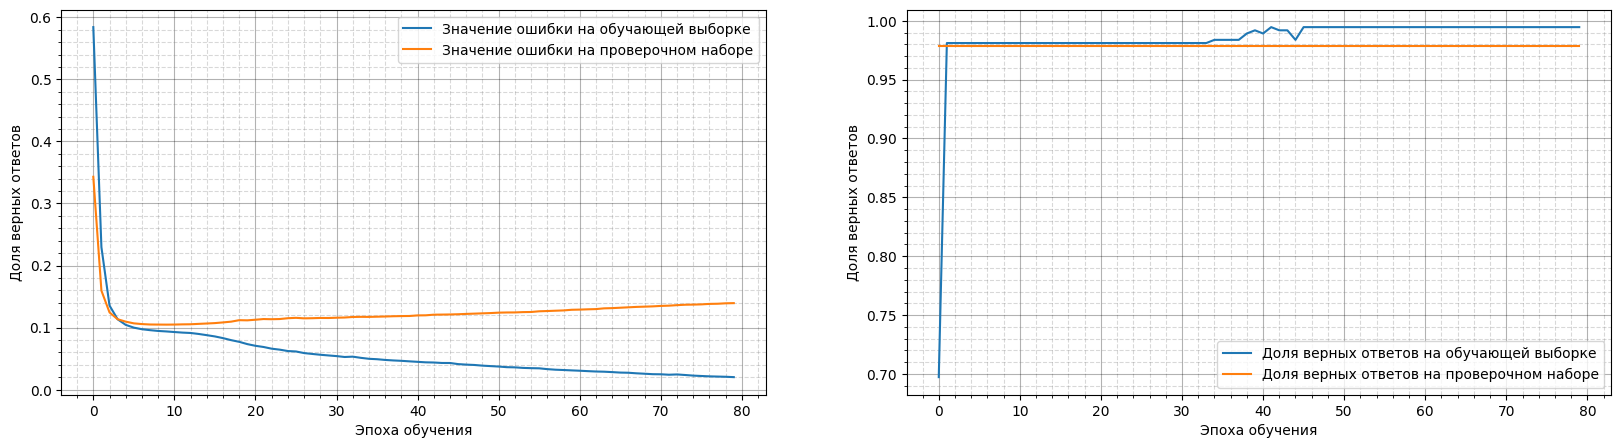

4/4 [==============================] - 0s 5ms/step - loss: 0.1184 - accuracy: 0.9828
Процент верных ответов на тестовых данных: 98.0 %


In [ ]:
model = func_create_model()

history = func_fit_model(model)

plot = func_plot(history)

func_evaluate(model)


Наглядно видно, что на обучающей выборке ошибка стремится к 0, а на проверочной выборке ошибка снижается, но потом снова растет. Это эффект переобучения. Выделяю две основные причины: маленькая и разбалансированная база.

4/4 [==============================] - 0s 3ms/step
Accuracy: 0.99
Precision: 1.00
Recall: 0.56
F1 score: 0.71
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
F1 score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


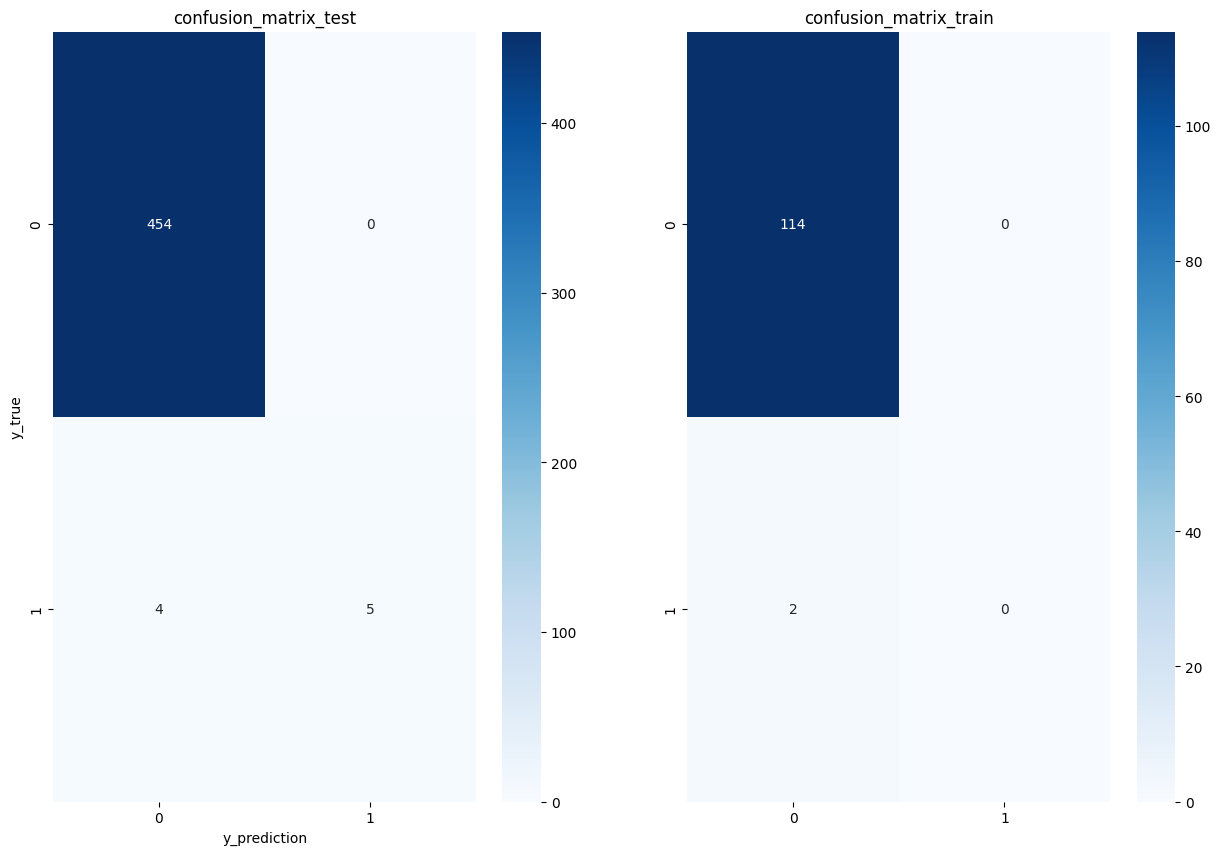

In [ ]:
func_predict(model)

По confusion matrix видно, что из-за несбалансированного датасета сеть видела немного положительных меток и в 50% случаев обучающей выборки она не определяет правильно метку.
Также в тренировочной выборке метка определена неправильно.

### с текстовыми данными

Epoch 1/80
19/19 [==============================] - 2s 14ms/step - loss: 0.4136 - accuracy: 0.9865 - val_loss: 0.2980 - val_accuracy: 0.9570
Epoch 2/80
19/19 [==============================] - 0s 6ms/step - loss: 0.2024 - accuracy: 0.9865 - val_loss: 0.2125 - val_accuracy: 0.9570
Epoch 3/80
19/19 [==============================] - 0s 6ms/step - loss: 0.1446 - accuracy: 0.9865 - val_loss: 0.1814 - val_accuracy: 0.9570
Epoch 4/80
19/19 [==============================] - 0s 6ms/step - loss: 0.1189 - accuracy: 0.9865 - val_loss: 0.1662 - val_accuracy: 0.9570
Epoch 5/80
19/19 [==============================] - 0s 6ms/step - loss: 0.1023 - accuracy: 0.9865 - val_loss: 0.1581 - val_accuracy: 0.9570
Epoch 6/80
19/19 [==============================] - 0s 6ms/step - loss: 0.0902 - accuracy: 0.9865 - val_loss: 0.1540 - val_accuracy: 0.9570
Epoch 7/80
19/19 [==============================] - 0s 6ms/step - loss: 0.0805 - accuracy: 0.9865 - val_loss: 0.1512 - val_accuracy: 0.9570
Epoch 8/80
19/19 [=

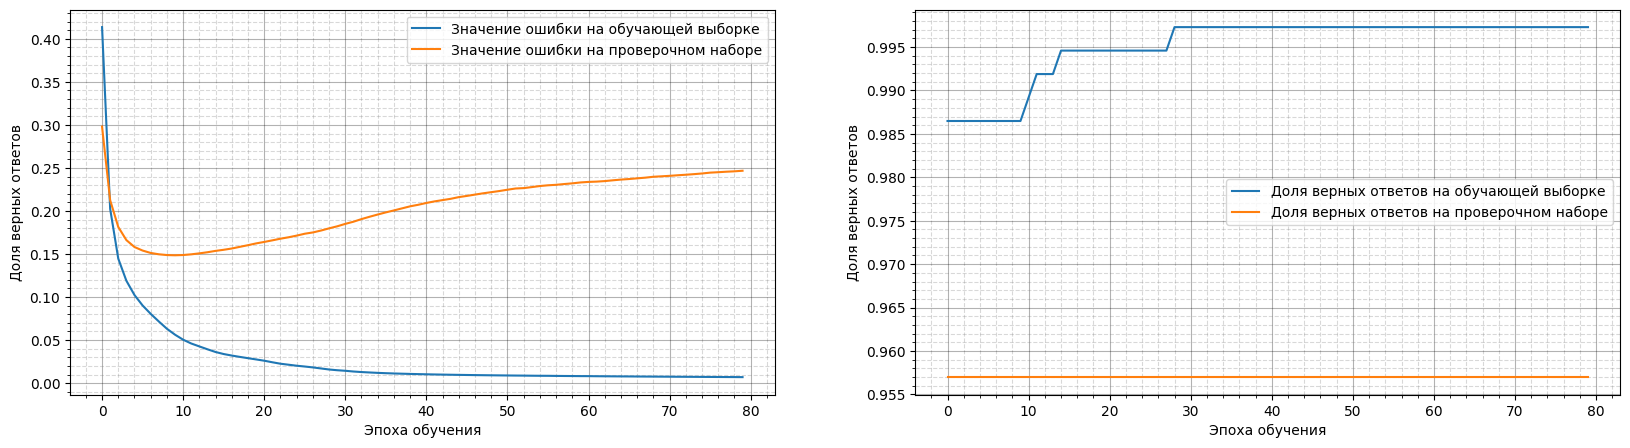

4/4 [==============================] - 0s 7ms/step - loss: 0.1105 - accuracy: 0.9828
Процент верных ответов на тестовых данных: 98.0 %


In [ ]:
model_text = func_create_model("text")

history_text = func_fit_model(model_text, "text")

plot_text = func_plot(history_text)

func_evaluate(model_text, "text")


4/4 [==============================] - 0s 3ms/step
Accuracy: 0.99
Precision: 1.00
Recall: 0.44
F1 score: 0.62
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
F1 score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


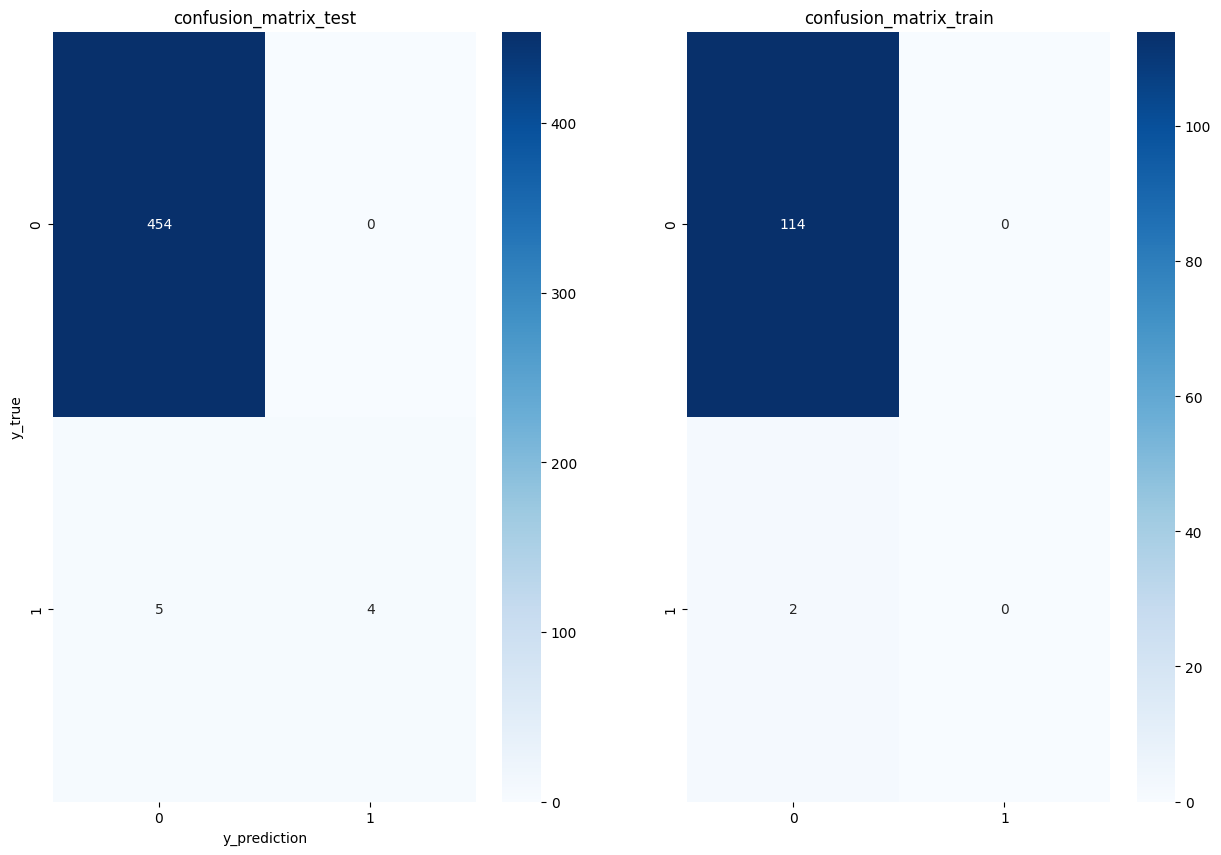

In [ ]:
func_predict(model_text, "text")

Практически аналогично предыдущему случаю.

### Составная НС (без текста + с текстом)

In [ ]:
input1 = Input((x_train.shape[1],))
input2 = Input((x_train_text.shape[1],))

x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.5)(x1)
x1 = Dense(25, activation="relu")(x1)
x1 = Dense(5, activation="relu")(x1)
x1 = Dense(5, activation = "relu")(x1)

x2 = BatchNormalization()(input2) # Создаем ветку х2
x2 = Dense(1000, activation="relu")(input2)
x2 = Dense(100, activation="tanh")(x2)
x2 = Dense(20, activation = "elu")(x2)

x = concatenate([x1, x2]) # Объединяем все ветки

x = Dense(15, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='relu')(x) # Финальный нейрон, делает регрессию

model_compose = Model((input1, input2), x) # В Model загружаем стартовые и последнюю точки

model_compose.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_compose = model_compose.fit([xTrain[:425], xTrain_text[:425]],
                    yTrain[:425],
                    epochs= 150,
                    validation_data=([xTrain[425:], xTrain_text[425:]],
                    yTrain[425:]),
                    verbose=1, shuffle=True)


Epoch 1/150
14/14 [==============================] - 6s 27ms/step - loss: 0.3737 - accuracy: 0.9741 - val_loss: 0.1002 - val_accuracy: 0.9935
Epoch 2/150
14/14 [==============================] - 0s 18ms/step - loss: 0.3629 - accuracy: 0.9765 - val_loss: 0.1002 - val_accuracy: 0.9935
Epoch 3/150
14/14 [==============================] - 0s 17ms/step - loss: 0.3629 - accuracy: 0.9765 - val_loss: 0.1002 - val_accuracy: 0.9935
Epoch 4/150
14/14 [==============================] - 0s 16ms/step - loss: 0.3629 - accuracy: 0.9765 - val_loss: 0.1002 - val_accuracy: 0.9935
Epoch 5/150
14/14 [==============================] - 0s 16ms/step - loss: 0.3629 - accuracy: 0.9765 - val_loss: 0.1002 - val_accuracy: 0.9935
Epoch 6/150
14/14 [==============================] - 0s 15ms/step - loss: 0.3629 - accuracy: 0.9765 - val_loss: 0.1002 - val_accuracy: 0.9935
Epoch 7/150
14/14 [==============================] - 0s 13ms/step - loss: 0.3629 - accuracy: 0.9765 - val_loss: 0.1002 - val_accuracy: 0.9935
Epoch 

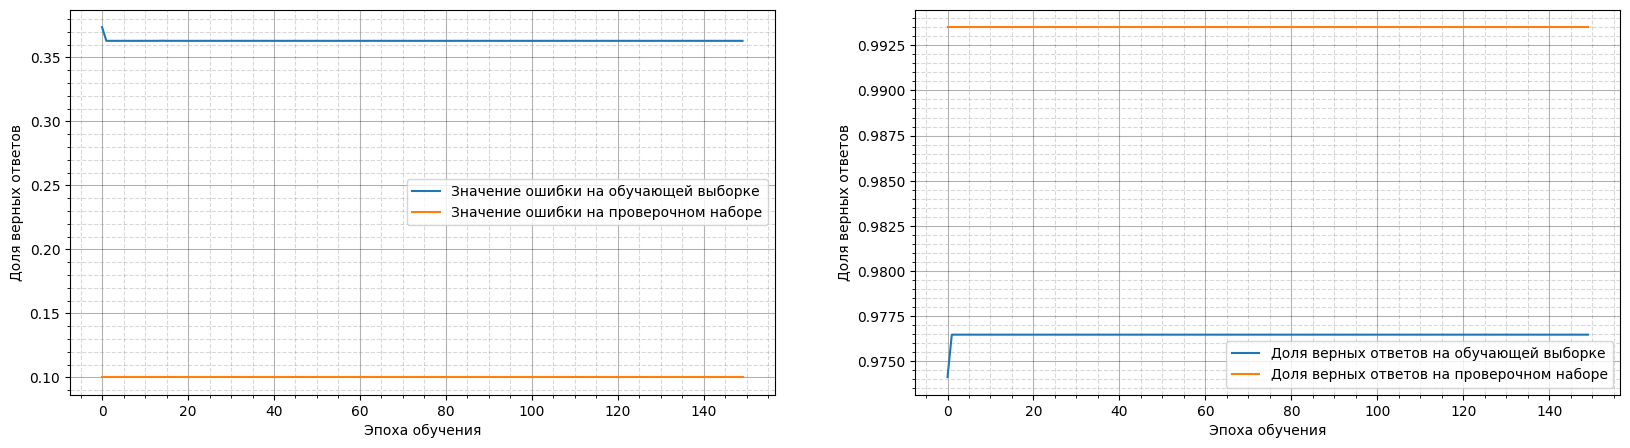

In [ ]:
plot_compose = func_plot(history_compose)


4/4 [==============================] - 0s 3ms/step
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
F1 score: 0.00
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
F1 score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


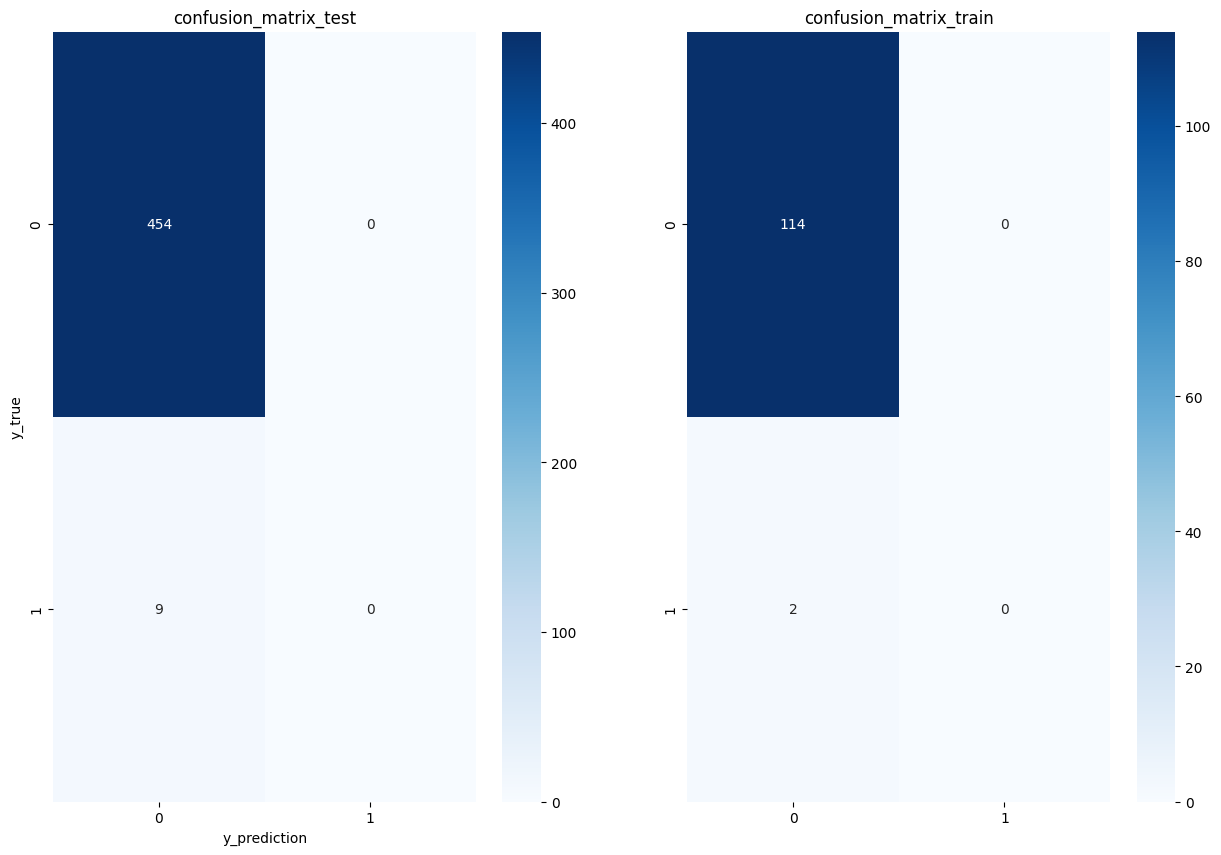

In [ ]:
# Вывод результатов оценки работы модели на тестовых данных
y_predict_train = model_compose.predict([x_train, x_train_text])
y_predict_test = model_compose.predict([x_test, x_test_text])

# Матрица ошибок классификатора
confusion_matrix_train = metrics.confusion_matrix(y_train, y_predict_train.round())
confusion_matrix_test = metrics.confusion_matrix(y_test, y_predict_test.round())

# Отрисовка матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize = (15, 10)) # фигура + 2 координатные плоскости

# Тепловая карта для первой матрицы ошибок
sns.heatmap(confusion_matrix_train, annot = True, fmt = '', ax = axes[0], cmap = 'Blues')
axes[1].set_title('confusion_matrix_train')
axes[1].set_xlabel('y_prediction')
axes[1].set_ylabel('y_true')

# Тепловая карта для второй матрицы ошибок
sns.heatmap(confusion_matrix_test, annot = True, fmt = '', ax = axes[1], cmap = 'Blues')
axes[0].set_title('confusion_matrix_test')
axes[0].set_xlabel('y_prediction')
axes[0].set_ylabel('y_true')

# Вывод текстом
print(f'Accuracy: {metrics.accuracy_score(y_train, y_predict_train.round()):.2f}')
#Рассчет precision
print(f'Precision: {metrics.precision_score(y_train, y_predict_train.round()):.2f}')
#Рассчет recall
print(f'Recall: {metrics.recall_score(y_train, y_predict_train.round()):.2f}')
#Рассчет F1
print(f'F1 score: {metrics.f1_score(y_train, y_predict_train.round()):.2f}')

print(f'Accuracy: {metrics.accuracy_score(y_test, y_predict_test.round()):.2f}')
print(f'Precision: {metrics.precision_score(y_test, y_predict_test.round()):.2f}')
print(f'Recall: {metrics.recall_score(y_test, y_predict_test.round()):.2f}')
print(f'F1 score: {metrics.f1_score(y_test, y_predict_test.round()):.2f}')

Стало только хуже.

Попробую выделить только 2 вакансии, по которым наибольшее количество положительных меток.

## Тесты на данных датасета с изменениями (на две вакансии: "Growth Product Manager" и "HR-специалист")

Выделяю две вакансии с максимальным количеством положительных меток в датасете: "Growth Product Manager" и "HR-специалист"

### Подготовка выборок для подачи в НС (с изменениями)

In [ ]:
(xTrain_test, yTrain_test) = training_sample(data2.values, ["Growth Product Manager", "HR-специалист"]) # Извлекаем значения загруженного набора данных

print('xTrain_test, yTrain_test:', xTrain_test.shape, yTrain_test.shape)

x_train_test, x_test_test, y_train_test, y_test_test = train_test_split(xTrain_test, yTrain_test, test_size=0.2) # Делим на тренировочную и тестовую выборку
#Выводим результирующие размеры таблиц
print('Train:', x_train_test.shape, y_train_test.shape)
print('Test:', x_test_test.shape, y_test_test.shape)

# Пример обработанных данных
n = 0
print(x_train_test[n])
print(y_train_test[n])

xTrain_test, yTrain_test: (313, 64) (313,)
Train: (250, 64) (250,)
Test: (63, 64) (63,)
[0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0
 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
0


### без текстовых данных (измененный датасет)

Epoch 1/80
25/25 [==============================] - 1s 10ms/step - loss: 0.4569 - accuracy: 0.9650 - val_loss: 0.3762 - val_accuracy: 0.9800
Epoch 2/80
25/25 [==============================] - 0s 5ms/step - loss: 0.3332 - accuracy: 0.9650 - val_loss: 0.2659 - val_accuracy: 0.9800
Epoch 3/80
25/25 [==============================] - 0s 5ms/step - loss: 0.2473 - accuracy: 0.9650 - val_loss: 0.1892 - val_accuracy: 0.9800
Epoch 4/80
25/25 [==============================] - 0s 4ms/step - loss: 0.1954 - accuracy: 0.9650 - val_loss: 0.1465 - val_accuracy: 0.9800
Epoch 5/80
25/25 [==============================] - 0s 4ms/step - loss: 0.1700 - accuracy: 0.9650 - val_loss: 0.1262 - val_accuracy: 0.9800
Epoch 6/80
25/25 [==============================] - 0s 5ms/step - loss: 0.1584 - accuracy: 0.9650 - val_loss: 0.1170 - val_accuracy: 0.9800
Epoch 7/80
25/25 [==============================] - 0s 5ms/step - loss: 0.1534 - accuracy: 0.9650 - val_loss: 0.1116 - val_accuracy: 0.9800
Epoch 8/80
25/25 [=

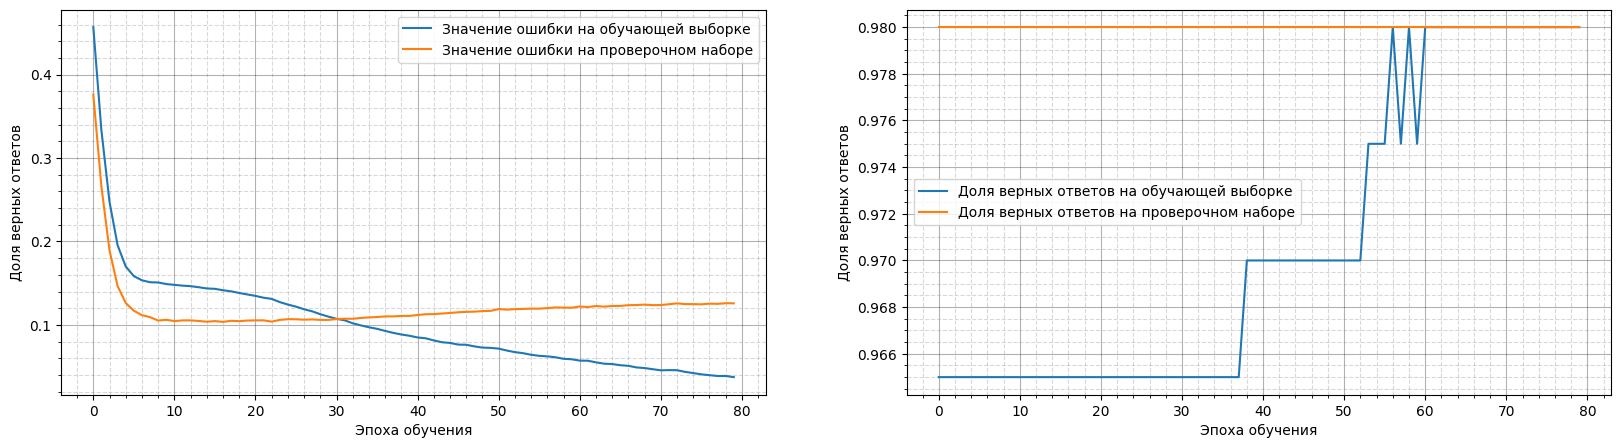

2/2 [==============================] - 0s 10ms/step - loss: 0.1020 - accuracy: 0.9841
Процент верных ответов на тестовых данных: 98.0 %


In [ ]:
# Измененный датасет используется по простым табличным данным

model_test = func_create_model("test")

history_test = func_fit_model(model_test, "test")

plot_test = func_plot(history_test)

func_evaluate(model_test, "test")


2/2 [==============================] - 0s 6ms/step
Accuracy: 0.98
Precision: 1.00
Recall: 0.38
F1 score: 0.55
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
F1 score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


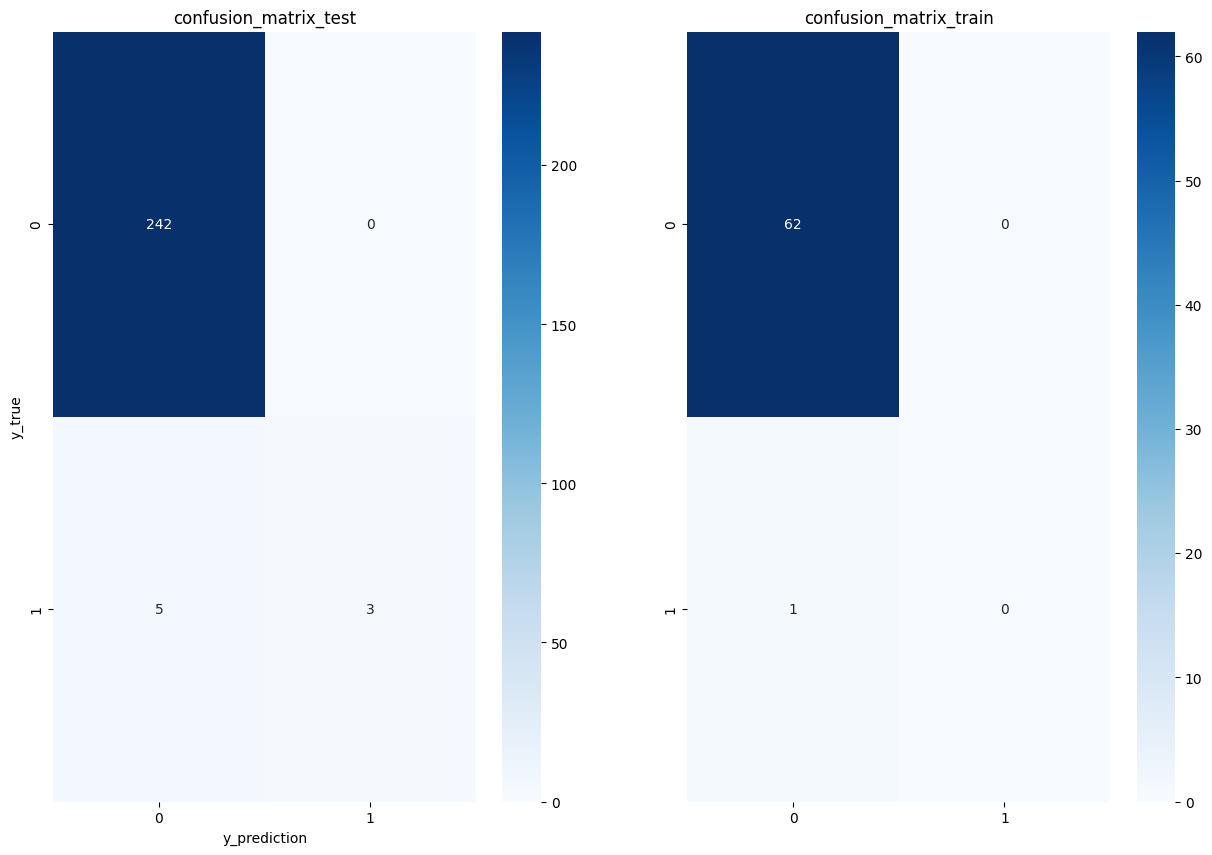

In [ ]:
func_predict(model_test, "test")

С датасетом только на 2 вакансии ошибается при ответах на положительных метках даже больше.  

### с текстовыми данными (измененный датасет)

In [ ]:
# Обработка текстов для измененного датасета (только по 2 вакансиям: "Growth Product Manager", "HR-специалист")

# Вытаскиваются текстовые данные и выводится пример
spisok_words_test = func_text(data2.values, ["Growth Product Manager", "HR-специалист"])
print("spisok_words_test[0]", spisok_words_test[0])

tokenizer.fit_on_texts(spisok_words_test) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items_test = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра

print("tokenizer_test", tokenizer)
print("items_test", items_test)

#преобразовываем текст в последовательность индексов согласно частотному словарю
spisok_words_indexes_test = tokenizer.texts_to_sequences(spisok_words_test) #обучающие тесты в индексы

n = 0
print("spisok_words_test[n]", spisok_words_test[n])       # Все текстовые поля по 1 человеку
print("spisok_words_indexes_test[n]", spisok_words_indexes_test[n]) # Все текстовые поля по 1 человеку через индексы

# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain_test_text = tokenizer.sequences_to_matrix(spisok_words_indexes_test) # Подаем в виде списка чтобы метод успешно сработал
print("xTrain_test_text.shape", xTrain_test_text.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print("xTrain_test_text[0][0:100]", xTrain_test_text[0][0:100])


313
spisok_words_test[0] PT MYBALI APP GROUP. Менеджер по продукту. Маркетинговые исследования. Исследование рынка; Исследование конкурентов; Исследование потребителей; Планирование рекламы.. Виды исследований: Опросы; Фокус-группы; Глубинные интервью; Эксперименты, полевые исследования.. Задачи в рамках исследования потребителей: Анализ потребительских трендов; Анализ обратной связи от клиентов; Сегментация аудитории; Составление портрета целевой аудитории.. Реклама у лидеров мнений. Организация и контроль взаимодействия с лидерами мнений (селебрити, блогеры).. Опыт организации коллабораций.. SMM и комьюнити-менеджмент. Планирование продвижения; Создание и контроль контента; Наполнение аккаунтов, сообществ; Модерирование и развитие аккаунтов, сообществ.. Социальные сети: Telegram.. Прямая реклама. Разработка программ лояльности.Составление и тестирование гипотез. Анализ конкурентов. Изучение потребностей потребителя ( касдев, проведения интервью) CJM Работа с UX/UR Визуализация данных

In [ ]:
# Для измененного датасета (только по 2 вакансиям: "Growth Product Manager", "HR-специалист")

x_train_test_text, x_test_test_text, y_train_test_text, y_test_test_text = train_test_split(xTrain_test_text, yTrain_test, test_size=0.2) # Делим на тренировочную и тестовую выборку для текстовых данных
#Выводим результирующие размеры таблиц
print('Train:', x_train_test_text.shape, y_train_test_text.shape)
print('Test:', x_test_test_text.shape, y_test_test_text.shape)

# Пример обработанных данных
n = 0
print(x_train_test_text[n])
print(y_train_test_text[n])

Train: (250, 10000) (250,)
Test: (63, 10000) (63,)
[0. 1. 1. ... 0. 0. 0.]
0


Epoch 1/80
25/25 [==============================] - 2s 11ms/step - loss: 0.4662 - accuracy: 0.8650 - val_loss: 0.2700 - val_accuracy: 1.0000
Epoch 2/80
25/25 [==============================] - 0s 5ms/step - loss: 0.2296 - accuracy: 0.9650 - val_loss: 0.1512 - val_accuracy: 1.0000
Epoch 3/80
25/25 [==============================] - 0s 5ms/step - loss: 0.1721 - accuracy: 0.9650 - val_loss: 0.1129 - val_accuracy: 1.0000
Epoch 4/80
25/25 [==============================] - 0s 5ms/step - loss: 0.1479 - accuracy: 0.9650 - val_loss: 0.0905 - val_accuracy: 1.0000
Epoch 5/80
25/25 [==============================] - 0s 5ms/step - loss: 0.1263 - accuracy: 0.9650 - val_loss: 0.0786 - val_accuracy: 1.0000
Epoch 6/80
25/25 [==============================] - 0s 5ms/step - loss: 0.1086 - accuracy: 0.9650 - val_loss: 0.0689 - val_accuracy: 1.0000
Epoch 7/80
25/25 [==============================] - 0s 5ms/step - loss: 0.0947 - accuracy: 0.9650 - val_loss: 0.0587 - val_accuracy: 1.0000
Epoch 8/80
25/25 [=

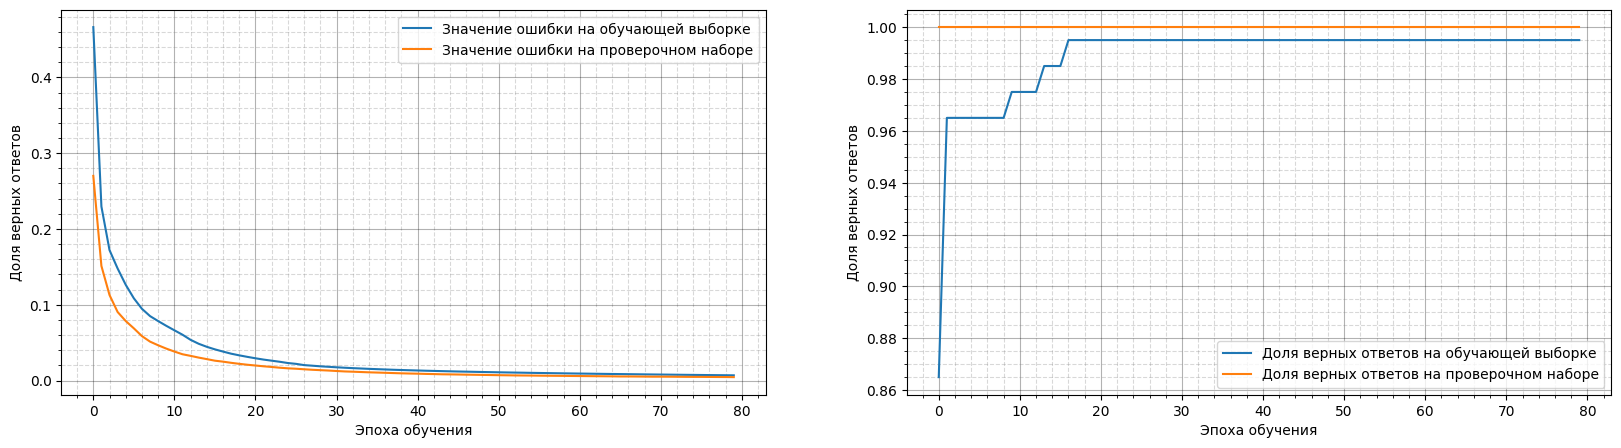

2/2 [==============================] - 0s 11ms/step - loss: 0.1961 - accuracy: 0.9683
Процент верных ответов на тестовых данных: 97.0 %


In [ ]:
# Измененный датасет используется по текстовым табличным данным

model_test_text = func_create_model("test_text")

history_test_text = func_fit_model(model_test_text, "test_text")

plot_test_text = func_plot(history_test_text)

func_evaluate(model_test_text, "test_text")


2/2 [==============================] - 0s 6ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 0.86
F1 score: 0.92
Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1 score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


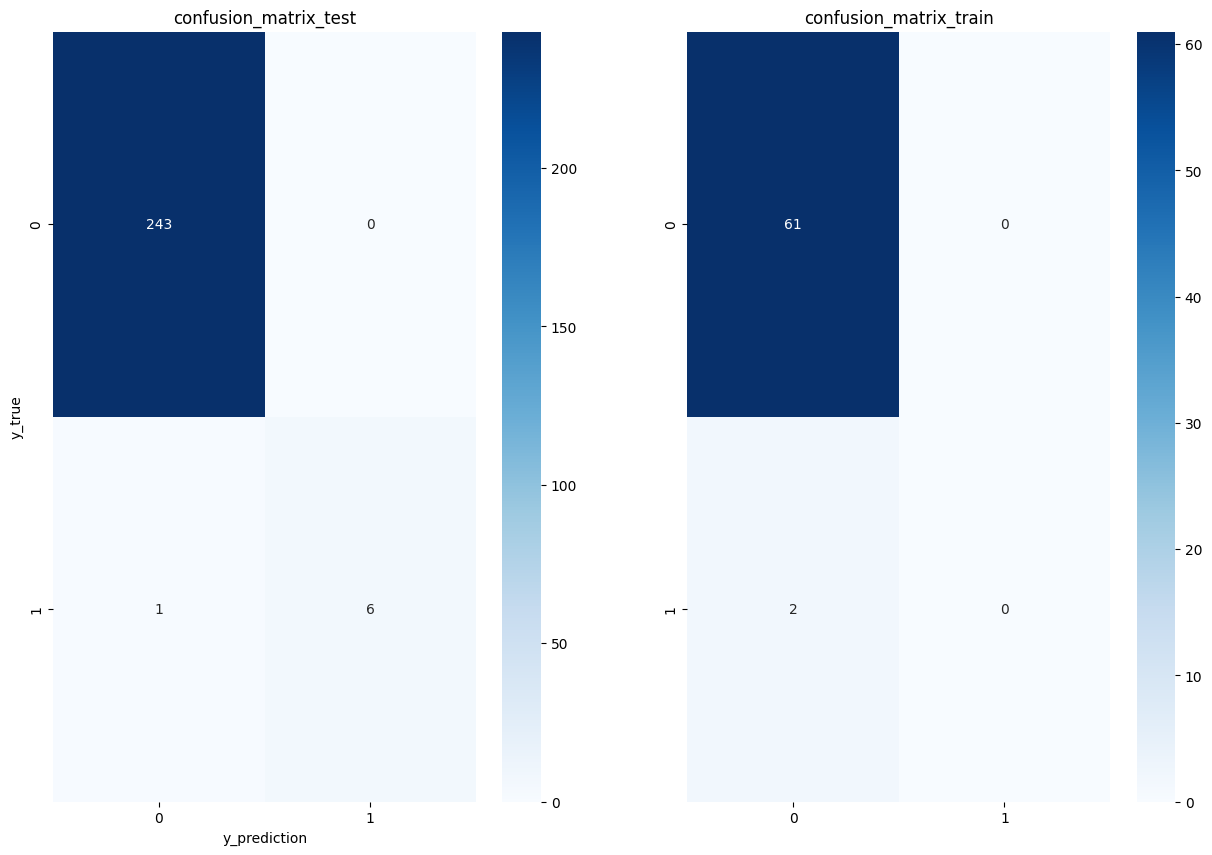

In [ ]:
func_predict(model_test_text, "test_text")

На обучающей выборке уже лучше, но на тесте ошибается.

Данные на обучения хоть и выше 95%, но в реальности обучается по факту только хорошо отрицательные метки определять.

### Составная НС (измененным датасет: без текста + с текстом)

In [ ]:
input1_test = Input((x_train_test.shape[1],))
input2_test = Input((x_train_test_text.shape[1],))

x1_test = BatchNormalization()(input1_test) # Создаем ветку х1_test
x1_test = Dropout(0.5)(x1_test)
x1_test = Dense(25, activation="relu")(x1_test)
x1_test = Dense(5, activation="relu")(x1_test)
x1_test = Dense(5, activation = "relu")(x1_test)

x2_test = BatchNormalization()(input2_test) # Создаем ветку х2_test
x2_test = Dense(1000, activation="relu")(x2_test)
x2_test = Dense(100, activation="tanh")(x2_test)
x2_test = Dense(20, activation = "elu")(x2_test)

x_test = concatenate([x1_test, x2_test]) # Объединяем все ветки

x_test = Dense(15, activation='relu')(x_test)
x_test = Dropout(0.5)(x_test)
x_test = Dense(1, activation='relu')(x_test) # Финальный нейрон, делает регрессию

model_compose_test = Model((input1_test, input2_test), x_test) # В Model загружаем стартовые и последнюю точки

model_compose_test.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_compose_test = model_compose_test.fit([xTrain_test[:200], xTrain_test_text[:200]],
                    yTrain_test[:200],
                    epochs= 150,
                    validation_data=([xTrain_test[200:], xTrain_test_text[200:]],
                    yTrain_test[200:]),
                    verbose=1, shuffle=True)


Epoch 1/150
8/8 [==============================] - 6s 63ms/step - loss: 0.9817 - accuracy: 0.9200 - val_loss: 0.2452 - val_accuracy: 0.9841
Epoch 2/150
8/8 [==============================] - 0s 20ms/step - loss: 0.8222 - accuracy: 0.9400 - val_loss: 0.2448 - val_accuracy: 0.9841
Epoch 3/150
8/8 [==============================] - 0s 17ms/step - loss: 0.4387 - accuracy: 0.9680 - val_loss: 0.2448 - val_accuracy: 0.9841
Epoch 4/150
8/8 [==============================] - 0s 18ms/step - loss: 0.4943 - accuracy: 0.9680 - val_loss: 0.2448 - val_accuracy: 0.9841
Epoch 5/150
8/8 [==============================] - 0s 18ms/step - loss: 0.4336 - accuracy: 0.9720 - val_loss: 0.2448 - val_accuracy: 0.9841
Epoch 6/150
8/8 [==============================] - 0s 15ms/step - loss: 0.4936 - accuracy: 0.9680 - val_loss: 0.2448 - val_accuracy: 0.9841
Epoch 7/150
8/8 [==============================] - 0s 16ms/step - loss: 0.4936 - accuracy: 0.9680 - val_loss: 0.2448 - val_accuracy: 0.9841
Epoch 8/150
8/8 [===

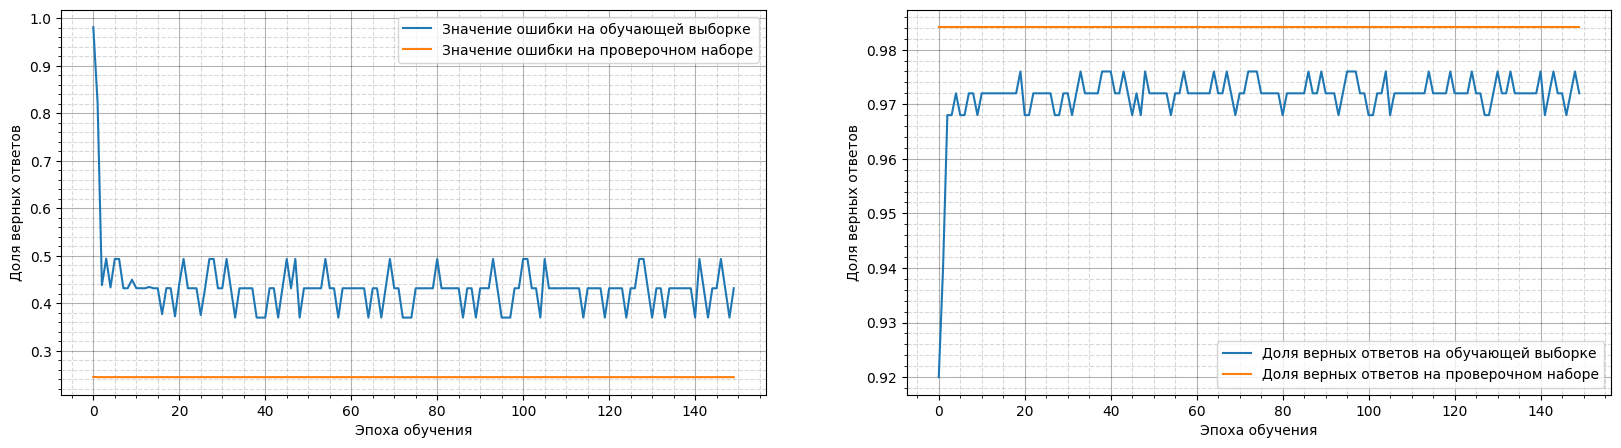

In [ ]:
plot_compose_test = func_plot(history_compose_test)

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.96
Precision: 0.00
Recall: 0.00
F1 score: 0.00
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
F1 score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


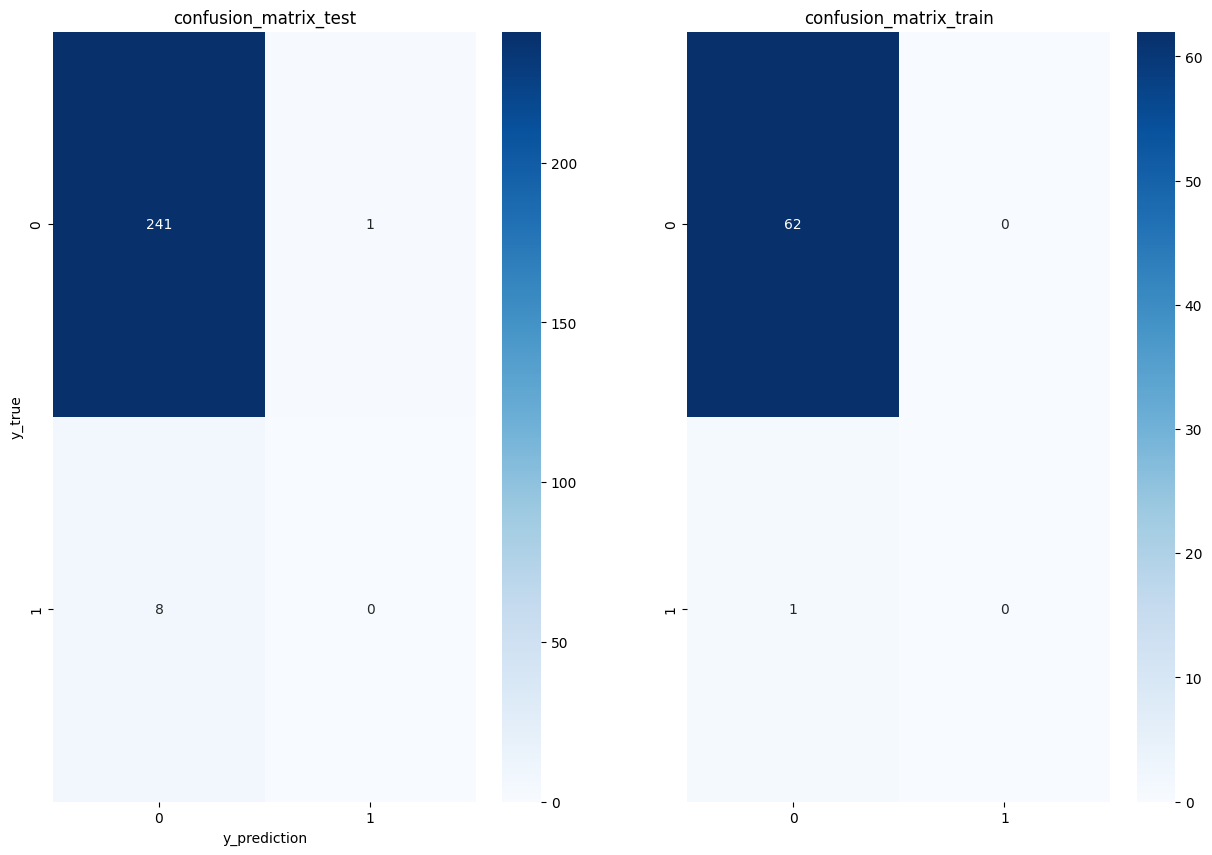

In [ ]:
# Вывод результатов оценки работы модели на тестовых данных
y_predict_train_test = model_compose_test.predict([x_train_test, x_train_test_text])
y_predict_test_test = model_compose_test.predict([x_test_test, x_test_test_text])

# Матрица ошибок классификатора
confusion_matrix_train_test = metrics.confusion_matrix(y_train_test, y_predict_train_test.round())
confusion_matrix_test_test = metrics.confusion_matrix(y_test_test, y_predict_test_test.round())

# Отрисовка матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize = (15, 10)) # фигура + 2 координатные плоскости

# Тепловая карта для первой матрицы ошибок
sns.heatmap(confusion_matrix_train_test, annot = True, fmt = '', ax = axes[0], cmap = 'Blues')
axes[1].set_title('confusion_matrix_train')
axes[1].set_xlabel('y_prediction')
axes[1].set_ylabel('y_true')

# Тепловая карта для второй матрицы ошибок
sns.heatmap(confusion_matrix_test_test, annot = True, fmt = '', ax = axes[1], cmap = 'Blues')
axes[0].set_title('confusion_matrix_test')
axes[0].set_xlabel('y_prediction')
axes[0].set_ylabel('y_true')

# Вывод текстом
print(f'Accuracy: {metrics.accuracy_score(y_train_test, y_predict_train_test.round()):.2f}')
#Рассчет precision
print(f'Precision: {metrics.precision_score(y_train_test, y_predict_train_test.round()):.2f}')
#Рассчет recall
print(f'Recall: {metrics.recall_score(y_train_test, y_predict_train_test.round()):.2f}')
#Рассчет F1
print(f'F1 score: {metrics.f1_score(y_train_test, y_predict_train_test.round()):.2f}')

print(f'Accuracy: {metrics.accuracy_score(y_test_test, y_predict_test_test.round()):.2f}')
print(f'Precision: {metrics.precision_score(y_test_test, y_predict_test_test.round()):.2f}')
print(f'Recall: {metrics.recall_score(y_test_test, y_predict_test_test.round()):.2f}')
print(f'F1 score: {metrics.f1_score(y_test_test, y_predict_test_test.round()):.2f}')

Хорошо обучается определять отрицательные метки, а вот по положительным плохой результат.

Наглядно на файле проведу для сравнения.

## **Тестирование на файле**

### На датасете с 2 вакансиями

In [ ]:
# Создание нового датасета с измененными данными (с 2 вакансиями: "Growth Product Manager" и "HR-специалист").
# Он у меня уже обработан, поэтому не буду его загружать и обрабатывать. Для загрузки файла нужно будет раскомментить слудующий блок кода внизу.

dataset = data2.loc[data2["Ищет работу на должность"].isin(["Growth Product Manager", "HR-специалист"])]

dataset.info()
dataset.head(20)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 313 entries, 0 to 518
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Пол, возраст                                313 non-null    object
 1   ЗП                                          313 non-null    object
 2   Ищет работу на должность                    313 non-null    object
 3   Город                                       313 non-null    object
 4   Занятость                                   313 non-null    object
 5   График                                      313 non-null    object
 6   Опыт ()                                     313 non-null    object
 7   Последнее/нынешное место работы             313 non-null    object
 8   Последняя/нынешняя должность                313 non-null    object
 9   Выполняемые задачи на прошлых местах работ  313 non-null    object
 10  Обо мне                   

Пол, возраст             ЗП  \
0                                      Женщина    90 000 руб.   
1                                      Женщина     не указана   
2    Мужчина, 33 года, родился 23 августа 1989   150 000 руб.   
3     Мужчина, 32 года, родился 7 декабря 1990     не указана   
4     Мужчина, 26 лет, родился 21 февраля 1996   150 000 руб.   
7    Женщина, 24 года, родилась 27 апреля 1998    30 000 руб.   
8       Женщина, 31 год, родилась 16 июля 1991    40 000 руб.   
9     Женщина, 28 лет, родилась 5 декабря 1994     не указана   
56       Женщина, 29 лет, родилась 3 июля 1993     не указана   
57                                     Мужчина     не указана   
58   Женщина, 37 лет, родилась 10 декабря 1985   120 000 руб.   
59  Женщина, 31 год, родилась 24 сентября 1991   200 000 руб.   
60        Мужчина, 28 лет, родился 31 мая 1994     не указана   
61   Мужчина, 26 лет, родился 16 сентября 1996     не указана   
62    Мужчина, 34 года, родился 13 апреля 1988     не указана   
63   Женщина, 31 год, родилась 15 августа 1991  1 900 000 KZT   
64    Мужчина, 26 лет, родился 24 октября 1996     не указана   
65     Мужчина, 30 лет, родился 29 апреля 1992     не указана   
66     Мужчина, 37 лет, родился 23 января 1986     не указана   
67     Мужчина, 31 год, родился 28 апреля 1991   100 000 руб.   

   Ищет работу на должность  \
0    Growth Product Manager   
1    Growth Product Manager   
2    Growth Product Manager   
3    Growth Product Manager   
4    Growth Product Manager   
7             HR-специалист   
8             HR-специалист   
9             HR-специалист   
56   Growth Product Manager   
57   Growth Product Manager   
58   Growth Product Manager   
59   Growth Product Manager   
60   Growth Product Manager   
61   Growth Product Manager   
62   Growth Product Manager   
63   Growth Product Manager   
64   Growth Product Manager   
65   Growth Product Manager   
66   Growth Product Manager   
67   Growth Product Manager   

                                                Город  \
0   Индонезия, Не готова к переезду, не готова к к...   
1   Москва, Готова к переезду, готова к командировкам   
2   Санкт-Петербург, Готов к переезду: Москва, гот...   
3   Москва, м. Молодежная, Хочу переехать, готов к...   
4        Пермь, Хочу переехать, готов к командировкам   
7   Уфа, Не готова к переезду, не готова к команди...   
8   Уфа, Не готова к переезду, не готова к команди...   
9   Уфа, Не готова к переезду, не готова к команди...   
56  Армения, Готова к переезду, готова к командиро...   
57    Москва, Готов к переезду, готов к командировкам   
58  Санкт-Петербург, м. Улица Дыбенко, Готова к пе...   
59  Москва, м. Южная, Не готова к переезду, не гот...   
60  Москва, м. Мякинино, Готов к переезду, готов к...   
61    Уфа, Готов к переезду, не готов к командировкам   
62  Самара, м. Спортивная, Готов к переезду, готов...   
63  Астана, Готова к переезду, готова к командировкам   
64  Армения, Не готов к переезду, готов к командир...   
65  Москва, Не готов к переезду, не готов к команд...   
66  Екатеринбург, Готов к переезду, готов к команд...   
67  Турция, Готов к переезду: Кыргызстан, Узбекист...   

                                            Занятость  \
0   проектная работа, частичная занятость, полная ...   
1                                    полная занятость   
2   проектная работа, частичная занятость, полная ...   
3   стажировка, частичная занятость, полная занятость   
4   проектная работа, частичная занятость, полная ...   
7                                    полная занятость   
8                                    полная занятость   
9                                    полная занятость   
56  проектная работа, частичная занятость, полная ...   
57  проектная работа, частичная занятость, полная ...   
58  проектная работа, частичная занятость, полная ...   
59                       стажировка, полная занятость   
60                 проектная работа, полная занятость   
61                  

In [ ]:
# !gdown 1gW8SkN6L73K1D7iB251fsyaOpBprBpll # загрузка файла в формате xlsx с гугл диска. Доступ должен быть открыт на чтение,
#                                          # числовой код индивидуален, вытащить вручную с юрл адреса файла.
#                                          # Колонки все те же самые, что и в датасете, который давали для обучения НС

# dataset = pd.read_excel("test.xlsx") # название датасета изменить на актуальное по названию файла

# #Удаляем лишнее
# dataset.dropna(axis=0, how='any')
# dataset.drop(["Unnamed: 0", "Дата отклика", "Обновление резюме"], axis=1, inplace=True)
# dataset.fillna(0, inplace=True)

# # Убираем кодировку ASCII (\xa0 - неразрывный пробел, \n - перенос строки) в текстовых строках
# for i in range(dataset.shape[1]):
#   for j in range(dataset.shape[0]):
#     if isinstance(dataset.values[j][i], (int, float)) == False:
#        dataset.values[j][i] = dataset.values[j][i].replace("\xa0", " ")
#        dataset.values[j][i] = dataset.values[j][i].replace("\n", " ")

# dataset = dataset.loc[dataset["Ищет работу на должность"].isin(["Growth Product Manager", "HR-специалист"])]

# dataset.info()
# dataset.head(20)

In [ ]:
# Формирование выборки из загруженного набора простых табличных данных
x_test_dataset, y_test_dataset = training_sample(dataset.values)

# Вытаскиваем из дататсета текстовые данные:
spisok_words_test_dataset = func_text(dataset.values)

# Преобразование текста в последовательность индексов, согласно частотному словарю созданному при обучении (!!!)
spisok_words_indexes_test_dataset = tokenizer.texts_to_sequences(spisok_words_test_dataset)            # преобразование текстов в индексы

# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
x_text_test_dataset = tokenizer.sequences_to_matrix(spisok_words_indexes_test_dataset) # Подаем в виде списка чтобы метод успешно сработал

predictions = model_compose_test.predict([x_test_dataset, x_text_test_dataset])  # используется та модель, которая составная только по 2 последним вакансиям

# Вычисление процентного распределения вероятностей
percentage = predictions * 100

# Формирование колонки "оценка резюме" в формате "подходит % / не подходит %"
evaluation = []
for p in percentage:
  evaluation.append(f"подходит {p[0]:.2f}% / не подходит {100 - p[0]:.2f}%")   # Форматирование f-строки поддерживается для обычных числовых типов данных, но не для массивов NumPy.
                                                                                    # Для избежания ошибки в выполнении кода  нужно применить форматирование f-строки к каждому элементу массива p в цикле.
# Добавление колонки "оценка резюме" в тестовый датасет
dataset['оценка резюме НС'] = evaluation


313
10/10 [==============================] - 0s 3ms/step


<ipython-input-58-8bdf40117fc9>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['оценка резюме НС'] = evaluation


In [ ]:
# Если нужно сохранить результат в файл, то раскоментить строку ниже
# test_dataset.to_excel('test_dataset.xlsx', index=True) #  Параметр index=False указывает, что индексы строк не должны быть

In [ ]:
dataset.head(20)

Пол, возраст             ЗП  \
0                                      Женщина    90 000 руб.   
1                                      Женщина     не указана   
2    Мужчина, 33 года, родился 23 августа 1989   150 000 руб.   
3     Мужчина, 32 года, родился 7 декабря 1990     не указана   
4     Мужчина, 26 лет, родился 21 февраля 1996   150 000 руб.   
7    Женщина, 24 года, родилась 27 апреля 1998    30 000 руб.   
8       Женщина, 31 год, родилась 16 июля 1991    40 000 руб.   
9     Женщина, 28 лет, родилась 5 декабря 1994     не указана   
56       Женщина, 29 лет, родилась 3 июля 1993     не указана   
57                                     Мужчина     не указана   
58   Женщина, 37 лет, родилась 10 декабря 1985   120 000 руб.   
59  Женщина, 31 год, родилась 24 сентября 1991   200 000 руб.   
60        Мужчина, 28 лет, родился 31 мая 1994     не указана   
61   Мужчина, 26 лет, родился 16 сентября 1996     не указана   
62    Мужчина, 34 года, родился 13 апреля 1988     не указана   
63   Женщина, 31 год, родилась 15 августа 1991  1 900 000 KZT   
64    Мужчина, 26 лет, родился 24 октября 1996     не указана   
65     Мужчина, 30 лет, родился 29 апреля 1992     не указана   
66     Мужчина, 37 лет, родился 23 января 1986     не указана   
67     Мужчина, 31 год, родился 28 апреля 1991   100 000 руб.   

   Ищет работу на должность  \
0    Growth Product Manager   
1    Growth Product Manager   
2    Growth Product Manager   
3    Growth Product Manager   
4    Growth Product Manager   
7             HR-специалист   
8             HR-специалист   
9             HR-специалист   
56   Growth Product Manager   
57   Growth Product Manager   
58   Growth Product Manager   
59   Growth Product Manager   
60   Growth Product Manager   
61   Growth Product Manager   
62   Growth Product Manager   
63   Growth Product Manager   
64   Growth Product Manager   
65   Growth Product Manager   
66   Growth Product Manager   
67   Growth Product Manager   

                                                Город  \
0   Индонезия, Не готова к переезду, не готова к к...   
1   Москва, Готова к переезду, готова к командировкам   
2   Санкт-Петербург, Готов к переезду: Москва, гот...   
3   Москва, м. Молодежная, Хочу переехать, готов к...   
4        Пермь, Хочу переехать, готов к командировкам   
7   Уфа, Не готова к переезду, не готова к команди...   
8   Уфа, Не готова к переезду, не готова к команди...   
9   Уфа, Не готова к переезду, не готова к команди...   
56  Армения, Готова к переезду, готова к командиро...   
57    Москва, Готов к переезду, готов к командировкам   
58  Санкт-Петербург, м. Улица Дыбенко, Готова к пе...   
59  Москва, м. Южная, Не готова к переезду, не гот...   
60  Москва, м. Мякинино, Готов к переезду, готов к...   
61    Уфа, Готов к переезду, не готов к командировкам   
62  Самара, м. Спортивная, Готов к переезду, готов...   
63  Астана, Готова к переезду, готова к командировкам   
64  Армения, Не готов к переезду, готов к командир...   
65  Москва, Не готов к переезду, не готов к команд...   
66  Екатеринбург, Готов к переезду, готов к команд...   
67  Турция, Готов к переезду: Кыргызстан, Узбекист...   

                                            Занятость  \
0   проектная работа, частичная занятость, полная ...   
1                                    полная занятость   
2   проектная работа, частичная занятость, полная ...   
3   стажировка, частичная занятость, полная занятость   
4   проектная работа, частичная занятость, полная ...   
7                                    полная занятость   
8                                    полная занятость   
9                                    полная занятость   
56  проектная работа, частичная занятость, полная ...   
57  проектная работа, частичная занятость, полная ...   
58  проектная работа, частичная занятость, полная ...   
59                       стажировка, полная занятость   
60                 проектная работа, полная занятость   
61                  

### На полном датасете (изначальном)

In [ ]:
# Создание нового датасета с полными данными (который изначально был).
# Он у меня уже обработан, поэтому не буду его загружать и обрабатывать. Для загрузки файла нужно будет раскомментить следующий блок кода внизу.

dataset_full = data2.copy()

In [ ]:
# !gdown 1gW8SkN6L73K1D7iB251fsyaOpBprBpll # загрузка файла в формате xlsx с гугл диска. Доступ должен быть открыт на чтение,
#                                          # числовой код индивидуален, вытащить вручную с юрл адреса файла.
#                                          # Колонки все те же самые, что и в датасете, который давали для обучения НС

# dataset_full = pd.read_excel("test.xlsx") # название датасета изменить на актуальное по названию файла

# #Удаляем лишнее
# dataset_full.dropna(axis=0, how='any')
# dataset_full.drop(["Unnamed: 0", "Дата отклика", "Обновление резюме"], axis=1, inplace=True)
# dataset_full.fillna(0, inplace=True)

# # Убираем кодировку ASCII (\xa0 - неразрывный пробел, \n - перенос строки) в текстовых строках
# for i in range(dataset_full.shape[1]):
#   for j in range(dataset_full.shape[0]):
#     if isinstance(dataset_full.values[j][i], (int, float)) == False:
#        dataset_full.values[j][i] = dataset_full.values[j][i].replace("\xa0", " ")
#        dataset_full.values[j][i] = dataset_full.values[j][i].replace("\n", " ")

# dataset_full.info()
# dataset_full.head(20)

In [ ]:
# Формирование выборки из загруженного набора простых табличных данных
x_test_dataset_full, y_test_dataset_full = training_sample(dataset_full.values)

# Вытаскиваем из дататсета текстовые данные:
spisok_words_test_dataset_full = func_text(dataset_full.values)

# Преобразование текста в последовательность индексов, согласно частотному словарю созданному при обучении (!!!)
spisok_words_indexes_test_dataset_full = tokenizer.texts_to_sequences(spisok_words_test_dataset_full)            # преобразование текстов в индексы

# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
x_text_test_dataset_full = tokenizer.sequences_to_matrix(spisok_words_indexes_test_dataset_full) # Подаем в виде списка чтобы метод успешно сработал

predictions_full = model_compose.predict([x_test_dataset_full, x_text_test_dataset_full])  # используется та модель, которая составная только по 2 последним вакансиям

# Вычисление процентного распределения вероятностей
percentage_full = predictions_full * 100

# Формирование колонки "оценка резюме" в формате "подходит % / не подходит %"
evaluation_full = []
for p in percentage_full:
  evaluation_full.append(f"подходит {p[0]:.2f}% / не подходит {100 - p[0]:.2f}%")   # Форматирование f-строки поддерживается для обычных числовых типов данных, но не для массивов NumPy.
                                                                                    # Для избежания ошибки в выполнении кода  нужно применить форматирование f-строки к каждому элементу массива p в цикле.

# Добавление колонки "оценка резюме" в тестовый датасет
dataset_full['Оценка резюме НС'] = evaluation_full


579
19/19 [==============================] - 0s 3ms/step


In [ ]:
# Если нужно сохранить результат в файл, то раскоментить строку ниже
# test_dataset_full.to_excel('test_dataset_full.xlsx', index=True) #  Параметр index=False указывает, что индексы строк не должны быть


In [ ]:
dataset_full.head(20)

Пол, возраст            ЗП  \
0                                      Женщина   90 000 руб.   
1                                      Женщина    не указана   
2    Мужчина, 33 года, родился 23 августа 1989  150 000 руб.   
3     Мужчина, 32 года, родился 7 декабря 1990    не указана   
4     Мужчина, 26 лет, родился 21 февраля 1996  150 000 руб.   
5       Женщина, 31 год, родилась 26 июня 1991  120 000 руб.   
6      Женщина, 36 лет, родилась 20 марта 1987  100 000 руб.   
7    Женщина, 24 года, родилась 27 апреля 1998   30 000 руб.   
8       Женщина, 31 год, родилась 16 июля 1991   40 000 руб.   
9     Женщина, 28 лет, родилась 5 декабря 1994    не указана   
10    Мужчина, 36 лет, родился 22 октября 1986    не указана   
11    Мужчина, 28 лет, родился 18 октября 1994   70 000 руб.   
12   Женщина, 41 год, родилась 21 декабря 1981    не указана   
13                                     Женщина   70 000 руб.   
14   Женщина, 58 лет, родилась 17 декабря 1964    не указана   
15    Женщина, 41 год, родилась 2 декабря 1981    не указана   
16      Женщина, 24 года, родилась 5 июня 1998   50 000 руб.   
17   Женщина, 42 года, родилась 19 ноября 1980    не указана   
18  Женщина, 58 лет, родилась 28 сентября 1964    не указана   
19    Женщина, 43 года, родилась 15 марта 1979   70 000 руб.   

                             Ищет работу на должность  \
0                              Growth Product Manager   
1                              Growth Product Manager   
2                              Growth Product Manager   
3                              Growth Product Manager   
4                              Growth Product Manager   
5            Product manager в Growth Hacking команду   
6                        Директор медицинской клиники   
7                                       HR-специалист   
8                                       HR-специалист   
9                                       HR-специалист   
10  Product Manager в команду Финансового департам...   
11  Product Manager в команду Финансового департам...   
12  Product Manager в команду Финансового департам...   
13  Product Manager в команду Финансового департам...   
14  Product Manager в команду Финансового департам...   
15  Product Manager в команду Финансового департам...   
16  Product Manager в команду Финансового департам...   
17  Product Manager в команду Финансового департам...   
18  Product Manager в команду Финансового департам...   
19  Product Manager в команду Финансового департам...   

                                                Город  \
0   Индонезия, Не готова к переезду, не готова к к...   
1   Москва, Готова к переезду, готова к командировкам   
2   Санкт-Петербург, Готов к переезду: Москва, гот...   
3   Москва, м. Молодежная, Хочу переехать, готов к...   
4        Пермь, Хочу переехать, готов к командировкам   
5   Индонезия, Не готова к переезду, не готова к к...   
6   Уфа, Не готова к переезду, готова к редким ком...   
7   Уфа, Не готова к переезду, не готова к команди...   
8   Уфа, Не готова к переезду, не готова к команди...   
9   Уфа, Не готова к переезду, не готова к команди...   
10    Уфа, Не готов к переезду, готов к командировкам   
11       Уфа, Готов к переезду, готов к командировкам   
12  Уфа, Не готова к переезду, не готова к команди...   
13  Уфа, Не готова к переезду, готова к редким ком...   
14  Уфа, Не готова к переезду, готова к редким ком...   
15  Уфа, Готова к переезду: Москва, Россия, Астрах...   
16     Уфа, Готова к переезду, готова к командировкам   
17  Санкт-Петербург, Готова к переезду: Москва, Ту...   
18  Энгальс, Готова к переезду, готова к редким ко...   
19  Уфа, Готова к переезду:  Москва, Екатеринбург,...   

                                            Занятость  \
0   проектная работа, частичная занятость, полная ...   
1                                    полная занятость   
2   проектная работа, частичная занятость, полная ...   
3   стажировка, частичная занятость, полная занятость   
4   прое

По 2 тестам на файле предварительные выводы подтвердились. Практически не подтверждаются положительные метки.

Попробую обучить НС по другим критериям, на категориальных данных

## **Тест с моделью на категориальных данных**

Все столбцы приводятся к одному значению: 0 или 1

Обучение и тестирование проведу на 2 вакансиях.

В выборку включу помимо табличных данных столбец "Ключевые навыки" переведенный в формат OHE

In [ ]:
data3 = data2.loc[data2["Ищет работу на должность"].isin(["Growth Product Manager", "HR-специалист"])]

data3.info()
data3.head(20)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 313 entries, 0 to 518
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Пол, возраст                                313 non-null    object
 1   ЗП                                          313 non-null    object
 2   Ищет работу на должность                    313 non-null    object
 3   Город                                       313 non-null    object
 4   Занятость                                   313 non-null    object
 5   График                                      313 non-null    object
 6   Опыт ()                                     313 non-null    object
 7   Последнее/нынешное место работы             313 non-null    object
 8   Последняя/нынешняя должность                313 non-null    object
 9   Выполняемые задачи на прошлых местах работ  313 non-null    object
 10  Обо мне                   

Пол, возраст             ЗП  \
0                                      Женщина    90 000 руб.   
1                                      Женщина     не указана   
2    Мужчина, 33 года, родился 23 августа 1989   150 000 руб.   
3     Мужчина, 32 года, родился 7 декабря 1990     не указана   
4     Мужчина, 26 лет, родился 21 февраля 1996   150 000 руб.   
7    Женщина, 24 года, родилась 27 апреля 1998    30 000 руб.   
8       Женщина, 31 год, родилась 16 июля 1991    40 000 руб.   
9     Женщина, 28 лет, родилась 5 декабря 1994     не указана   
56       Женщина, 29 лет, родилась 3 июля 1993     не указана   
57                                     Мужчина     не указана   
58   Женщина, 37 лет, родилась 10 декабря 1985   120 000 руб.   
59  Женщина, 31 год, родилась 24 сентября 1991   200 000 руб.   
60        Мужчина, 28 лет, родился 31 мая 1994     не указана   
61   Мужчина, 26 лет, родился 16 сентября 1996     не указана   
62    Мужчина, 34 года, родился 13 апреля 1988     не указана   
63   Женщина, 31 год, родилась 15 августа 1991  1 900 000 KZT   
64    Мужчина, 26 лет, родился 24 октября 1996     не указана   
65     Мужчина, 30 лет, родился 29 апреля 1992     не указана   
66     Мужчина, 37 лет, родился 23 января 1986     не указана   
67     Мужчина, 31 год, родился 28 апреля 1991   100 000 руб.   

   Ищет работу на должность  \
0    Growth Product Manager   
1    Growth Product Manager   
2    Growth Product Manager   
3    Growth Product Manager   
4    Growth Product Manager   
7             HR-специалист   
8             HR-специалист   
9             HR-специалист   
56   Growth Product Manager   
57   Growth Product Manager   
58   Growth Product Manager   
59   Growth Product Manager   
60   Growth Product Manager   
61   Growth Product Manager   
62   Growth Product Manager   
63   Growth Product Manager   
64   Growth Product Manager   
65   Growth Product Manager   
66   Growth Product Manager   
67   Growth Product Manager   

                                                Город  \
0   Индонезия, Не готова к переезду, не готова к к...   
1   Москва, Готова к переезду, готова к командировкам   
2   Санкт-Петербург, Готов к переезду: Москва, гот...   
3   Москва, м. Молодежная, Хочу переехать, готов к...   
4        Пермь, Хочу переехать, готов к командировкам   
7   Уфа, Не готова к переезду, не готова к команди...   
8   Уфа, Не готова к переезду, не готова к команди...   
9   Уфа, Не готова к переезду, не готова к команди...   
56  Армения, Готова к переезду, готова к командиро...   
57    Москва, Готов к переезду, готов к командировкам   
58  Санкт-Петербург, м. Улица Дыбенко, Готова к пе...   
59  Москва, м. Южная, Не готова к переезду, не гот...   
60  Москва, м. Мякинино, Готов к переезду, готов к...   
61    Уфа, Готов к переезду, не готов к командировкам   
62  Самара, м. Спортивная, Готов к переезду, готов...   
63  Астана, Готова к переезду, готова к командировкам   
64  Армения, Не готов к переезду, готов к командир...   
65  Москва, Не готов к переезду, не готов к команд...   
66  Екатеринбург, Готов к переезду, готов к команд...   
67  Турция, Готов к переезду: Кыргызстан, Узбекист...   

                                            Занятость  \
0   проектная работа, частичная занятость, полная ...   
1                                    полная занятость   
2   проектная работа, частичная занятость, полная ...   
3   стажировка, частичная занятость, полная занятость   
4   проектная работа, частичная занятость, полная ...   
7                                    полная занятость   
8                                    полная занятость   
9                                    полная занятость   
56  проектная работа, частичная занятость, полная ...   
57  проектная работа, частичная занятость, полная ...   
58  проектная работа, частичная занятость, полная ...   
59                       стажировка, полная занятость   
60                 проектная работа, полная занятость   
61                  

In [ ]:
# Выделяю столбцы с текстовыми данными в отдельный датасет
data3_text = data3[["Выполняемые задачи на прошлых местах работ", "Обо мне", "Подходит - да/нет"]]

# Удаляю текстовые столбцы из датасета
data3.drop(["Выполняемые задачи на прошлых местах работ", "Обо мне"], axis=1, inplace=True)

<ipython-input-43-c872b5a0456b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.drop(["Выполняемые задачи на прошлых местах работ", "Обо мне"], axis=1, inplace=True)


###**Собираем табличные данные** (кроме столбцов "Выполняемые задачи на прошлых местах работ", "Обо мне")

In [ ]:
# Переведу в OHE столбец ключевые навыки

key_skills = data3['Ключевые навыки'].str.get_dummies(sep='. ')

data3.drop(['Ключевые навыки'], axis=1, inplace=True)


<ipython-input-44-e83811c8839e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.drop(['Ключевые навыки'], axis=1, inplace=True)


In [ ]:
# Добавляем нужные колонки и удаляем ненужные

# Пол, возраст
def func_gender1(arg):
  if "М" in arg: return 1
  else: return 0

def func_age1(arg):
  phrase_split = arg.split(",")
  if len(phrase_split) > 1:
    year = int(re.findall(r'\d+', phrase_split[1])[0])
  else:
    year = 0
  return year

data3["Пол"] = data3["Пол, возраст"].apply(func_gender1)
data3["Возраст"] = data3["Пол, возраст"].apply(func_age1)
data3.drop(["Пол, возраст"], axis=1, inplace=True)


# Зарплата
def func_salary1(arg):
  num = arg

  if (type(num) == str):
    if num == "не указана":
      num = 1
      curr = "руб"
    else:
      # Убираем цифры, получаем в какой валюте
      curr = re.sub('[0-9]','',arg)
      curr = curr.replace('.','').strip()

      # Убираем лишние знаки, получаем число
      num = re.sub(' ','',num)
      num = re.sub('[а-яА-ЯёЁ]','',num)
      num = re.sub('[a-zA-Z]','',num)
      num = num.replace('.','')

      if curr == 'грн':
        curr = 'UAH'
      elif curr == 'белруб':
        curr = 'BYN'
      elif curr == 'сум':
        curr = 'UZS'

    # Конвертируем в рубли, если валюта
    if curr != "руб":
      text = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').text # запрос данных по валютам
      all_value = json.loads(text)
      value_num = all_value["Valute"][curr]["Value"]
      nominal = all_value["Valute"][curr]["Nominal"]
      if value_num != "":
        try:
          num = value_num / nominal * float(num)
        except KeyError:
          curr = "руб"
      else:
        curr = "руб"
  num = float(num)
  salary = num / 1000000.0

  return salary

data3["ЗП"] = data3["ЗП"].apply(func_salary1)


# Переезд и командировки
def func_relocation1(arg):
  if ("готова к переезду" or "готов к переезду" or "хочу переехать" in arg.lower()): return 1
  else: return 0

def func_relocation2(arg):
  if ("готова к командировкам" or "готов к командировкам" in arg.lower()): return 1
  else: return 0

data3["Готовность к переезду"] = data3["Город"].apply(func_relocation1)
data3["Готовность к командировкам"] = data3["Город"].apply(func_relocation2)


# Город
def func_city1(arg):
  if "москва" in arg.lower(): return 1
  else: return 0

def func_city2(arg):
  if "санкт-петербург" in arg.lower(): return 1
  else: return 0

def func_city3(arg):
  if "уфа" in arg.lower(): return 1
  else: return 0

def func_city4(arg):
  millionCities = "новосибирск екатеринбург нижний новгород казань челябинск омск самара ростов-на-дону красноярск пермь воронеж волгоград"
  sarg = arg.lower().split(',')
  for item in sarg:
    item = item.strip()
    if item in millionCities: return 1
  return 0

def func_city5(arg):
  Cities = "москва санкт-петербург уфа новосибирск екатеринбург нижний новгород казань челябинск омск самара ростов-на-дону красноярск пермь воронеж волгоград"
  spisok = ["готова к переезду", "готов к переезду", "хочу переехать", "готова к командировкам", "готов к командировкам"]
  sarg = arg.lower().split(',')
  for item in sarg:
    item = item.strip()
    if item in Cities and item in spisok: return 1
  return 0

data3["Москва"] = data3["Город"].apply(func_city1)
data3["Санкт-Петербург"] = data3["Город"].apply(func_city2)
data3["Уфа"] = data3["Город"].apply(func_city3)
data3["Города миллионники"] = data3["Город"].apply(func_city4)
data3["Другие города/страны"] = data3["Город"].apply(func_city5)

data3.drop(["Город"], axis=1, inplace=True)


# Занятость
def func_employment1(arg):
    if "стажировка" in arg.lower(): return 1
    else: return 0

def func_employment2(arg):
    if "волонтерство" in arg.lower(): return 1
    else: return 0

def func_employment3(arg):
    if "проектная работа" in arg.lower(): return 1
    else: return 0

def func_employment4(arg):
    if "частичная занятость" in arg.lower(): return 1
    else: return 0

def func_employment5(arg):
    if "неполный рабочий день" in arg.lower(): return 1
    else: return 0

def func_employment6(arg):
    if "полная занятость" in arg.lower(): return 1
    else: return 0

data3["Стажировка"] = data3["Занятость"].apply(func_employment1)
data3["Волонтёрство"] = data3["Занятость"].apply(func_employment2)
data3["Проектная работа"] = data3["Занятость"].apply(func_employment3)
data3["Частичная занятость"] = data3["Занятость"].apply(func_employment4)
data3["Неполный рабочий день"] = data3["Занятость"].apply(func_employment5)
data3["Полная занятость"] = data3["Занятость"].apply(func_employment6)

data3.drop(['Занятость'], axis=1, inplace=True)


# График работы
def func_working_schedule(arg):
  out = [0, 0, 0, 0, 0]
  if ("вахтовый метод" in arg):    out[0]=1
  if ("удаленная работа" in arg):  out[1]=1
  if ("гибкий график" in arg):     out[2]=1
  if ("полный день" in arg):       out[3]=1
  if ("сменный график" in arg):    out[4]=1
  return out

def func_working_schedule1(arg):
    if "вахтовый метод" in arg.lower(): return 1
    else: return 0

def func_working_schedule2(arg):
    if "удаленная работа" in arg.lower(): return 1
    else: return 0

def func_working_schedule3(arg):
    if "гибкий график" in arg.lower(): return 1
    else: return 0

def func_working_schedule4(arg):
    if "полный день" in arg.lower(): return 1
    else: return 0

def func_working_schedule5(arg):
    if "сменный график" in arg.lower(): return 1
    else: return 0

data3["Вахтовый метод"] = data3["График"].apply(func_working_schedule1)
data3["Удалённая работа"] = data3["График"].apply(func_working_schedule2)
data3["Гибкий график"] = data3["График"].apply(func_working_schedule3)
data3["Полный день"] = data3["График"].apply(func_working_schedule4)
data3["Сменный график"] = data3["График"].apply(func_working_schedule5)

data3.drop(['График'], axis=1, inplace=True)


# Опыт работы
data3["Опыт работы (в месяцах)"] = data3["Опыт ()"].apply(func_work_experience)
data3.drop(["Опыт ()"], axis=1, inplace=True)


def func_education2(arg):
  out = func_education(arg)
  answer = ""
  if out[0] == 1: answer = "Бакалавр"
  if out[1] == 1: answer = "Высшее"
  if out[2] == 1: answer = "Среднее специальное"
  if out[3] == 1: answer = "Неоконченное высшее"
  if out[4] == 1: answer = "Среднее"
  if out[5] == 1: answer = "Среднее образование"
  if out[6] == 1: answer = "Доктор наук"
  if out[7] == 1: answer = "Кандидат наук"
  if out[8] == 1: answer = "Магистр"
  if out[9] == 1: answer = "нет образования"
  return answer

data3["Образование"] = data3["Образование и ВУЗ"].apply(func_education2)
data3.drop(["Образование и ВУЗ"], axis=1, inplace=True)


def func_final_result1(arg):
  if arg == "да" or arg == "Да": return 1
  else: return 0

data3["Подходит - да/нет"] = data3["Подходит - да/нет"].apply(func_final_result1)

data3.head(20)


<ipython-input-45-b4b450f748c7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3["Пол"] = data3["Пол, возраст"].apply(func_gender1)
<ipython-input-45-b4b450f748c7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3["Возраст"] = data3["Пол, возраст"].apply(func_age1)
<ipython-input-45-b4b450f748c7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

ЗП Ищет работу на должность  \
0   0.090000   Growth Product Manager   
1   0.000001   Growth Product Manager   
2   0.150000   Growth Product Manager   
3   0.000001   Growth Product Manager   
4   0.150000   Growth Product Manager   
7   0.030000            HR-специалист   
8   0.040000            HR-специалист   
9   0.000001            HR-специалист   
56  0.000001   Growth Product Manager   
57  0.000001   Growth Product Manager   
58  0.120000   Growth Product Manager   
59  0.200000   Growth Product Manager   
60  0.000001   Growth Product Manager   
61  0.000001   Growth Product Manager   
62  0.000001   Growth Product Manager   
63  0.386791   Growth Product Manager   
64  0.000001   Growth Product Manager   
65  0.000001   Growth Product Manager   
66  0.000001   Growth Product Manager   
67  0.100000   Growth Product Manager   

                      Последнее/нынешное место работы  \
0                                 PT MYBALI APP GROUP   
1                                       Банк Открытие   
2                                           DIKIY LLC   
3                                            WeInvest   
4   Индивидуальное предпринимательство / частная п...   
7                                               Tiqum   
8                                           МБОУ СОШ    
9                                    Газпромбанк, ОАО   
56                                   ПРОЕКТНАЯ РАБОТА   
57                                          ArrowLabs   
58                                       Ortho Baltic   
59                                        IT start up   
60                GameDev & MarTech | Beyond.GG, Inc.   
61                             Сенса компани Джорджиа   
62  Единая электронная торговая площадка, ОАО (гру...   
63                                  ТОО "Гис-Телеком"   
64                                      SoftConstruct   
65                               Сантехника-онлайн.Ру   
66  LLC INTUS windows. IT department.  Международн...   
67                   Девелоперская компания Easy Home   

                   Последняя/нынешняя должность  Подходит - да/нет  Пол  \
0                          Менеджер по продукту                  1    0   
1   Product owner трайб сбережения и инвестиции                  1    0   
2                                                                1    1   
3                 Product Manager (team leader)                  1    1   
4                       Product/Project manager                  1    1   
7                              Контент-менеджер                  1    0   
8           Учитель русского языка и литературы                  1    0   
9                                    Специалист                  1    0   
56                   БРЕНД - МАРКЕТИНГ МЕНЕДЖЕР                  0    0   
57                              Product manager                  0    1   
58      Product Manager, Senior Reseracher, PhD                  0    0   
59                                Product owner                  0    0   
60                        Руководитель проектов                  0    1   
61                Руководитель отдела логистики                  0    1   
62                     Руководитель направления                  0    1   
63                   Старший проектный менеджер                  0    0   
64                              Product Manager                  0    1   
65     Product Manager Личного кабинета клиента                  0    1   
66                                Product owner                  0    1   
67              Советник генерального директора                  0    1   

    Возраст  Готовность к переезду  Готовность к командировкам  Москва  ...  \
0         0                      1                           1       0  ...   
1         0                      1                           1       1  ...   
2        33                      1                           1       1  ...   
3        32                      1                        

In [ ]:
# Переводим в OHE остальные столбцы и присоединяем ключевые навыки

spisok_columns = ["Подходит - да/нет", "Пол", "Возраст", "ЗП", "Готовность к переезду", "Готовность к командировкам", "Москва", "Санкт-Петербург", "Уфа", "Города миллионники", "Другие города/страны", "Стажировка", "Волонтёрство", "Проектная работа", "Частичная занятость", "Неполный рабочий день", "Полная занятость", "Вахтовый метод", "Удалённая работа", "Гибкий график", "Полный день", "Сменный график", "Опыт работы (в месяцах)"]

data3 = pd.get_dummies(data3, columns=[col for col in data3.columns if col not in spisok_columns])
data3 = pd.concat([data3.reset_index(drop=True), key_skills.reset_index(drop=True)], axis=1)

data3.head(20)

ЗП  Подходит - да/нет  Пол  Возраст  Готовность к переезду  \
0   0.090000                  1    0        0                      1   
1   0.000001                  1    0        0                      1   
2   0.150000                  1    1       33                      1   
3   0.000001                  1    1       32                      1   
4   0.150000                  1    1       26                      1   
5   0.030000                  1    0       24                      1   
6   0.040000                  1    0       31                      1   
7   0.000001                  1    0       28                      1   
8   0.000001                  0    0       29                      1   
9   0.000001                  0    1        0                      1   
10  0.120000                  0    0       37                      1   
11  0.200000                  0    0       31                      1   
12  0.000001                  0    1       28                      1   
13  0.000001                  0    1       26                      1   
14  0.000001                  0    1       34                      1   
15  0.386791                  0    0       31                      1   
16  0.000001                  0    1       26                      1   
17  0.000001                  0    1       30                      1   
18  0.000001                  0    1       37                      1   
19  0.100000                  0    1       31                      1   

    Готовность к командировкам  Москва  Санкт-Петербург  Уфа  \
0                            1       0                0    0   
1                            1       1                0    0   
2                            1       1                1    0   
3                            1       1                0    0   
4                            1       0                0    0   
5                            1       0                0    1   
6                            1       0                0    1   
7                            1       0                0    1   
8                            1       0                0    0   
9                            1       1                0    0   
10                           1       0                1    0   
11                           1       1                0    0   
12                           1       1                0    0   
13                           1       0                0    1   
14                           1       0                0    0   
15                           1       0                0    0   
16                           1       0                0    0   
17                           1       1                0    0   
18                           1       0                0    0   
19                           1       0                0    0   

    Города миллионники  ...  эффективност  эффективности  юмора  юни  \
0                    0  ...             0              0      0    0   
1                    0  ...             0              0      0    0   
2                    0  ...             0              0      0    0   
3                    0  ...             0              0      0    0   
4                    1  ...             0              0      0    0   
5                    0  ...             0              0      0    0   
6                    0  ...             0              0      0    0   
7                    0  ...             0              0      0    0   
8                    0  ...             0              0      0    0   
9                    0  ...             0              0      0    0   
10                   0  ...             0              0      0    0   
11                   0  ...             0              0      0    0   
12                   0  ...             0              0      0    0   
13                   0  ...             0              0      0    0   
14                   1  ...             0              0      0    0   


In [ ]:
y_cat = data3["Подходит - да/нет"]
# data3.drop(["Подходит - да/нет"], axis=1, inplace=True)

data3["ЗП"] = data3["ЗП"].astype('float32')

# Делим на тренировочную и тестовую выборку
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(data3, y_cat, shuffle=True, test_size=0.2)

# Выводим результирующие размеры таблиц
print('Train:', x_train_cat.shape, y_train_cat.shape)
print('Test:',x_test_cat.shape, y_test_cat.shape)


Train: (250, 2579) (250,)
Test: (63, 2579) (63,)


Epoch 1/80
25/25 [==============================] - 1s 13ms/step - loss: 0.3385 - accuracy: 0.9750 - val_loss: 0.2086 - val_accuracy: 0.9800
Epoch 2/80
25/25 [==============================] - 0s 4ms/step - loss: 0.1810 - accuracy: 0.9750 - val_loss: 0.1362 - val_accuracy: 0.9800
Epoch 3/80
25/25 [==============================] - 0s 5ms/step - loss: 0.1378 - accuracy: 0.9750 - val_loss: 0.1009 - val_accuracy: 0.9800
Epoch 4/80
25/25 [==============================] - 0s 4ms/step - loss: 0.1207 - accuracy: 0.9750 - val_loss: 0.0921 - val_accuracy: 0.9800
Epoch 5/80
25/25 [==============================] - 0s 4ms/step - loss: 0.1171 - accuracy: 0.9750 - val_loss: 0.0923 - val_accuracy: 0.9800
Epoch 6/80
25/25 [==============================] - 0s 5ms/step - loss: 0.1162 - accuracy: 0.9750 - val_loss: 0.0929 - val_accuracy: 0.9800
Epoch 7/80
25/25 [==============================] - 0s 4ms/step - loss: 0.1148 - accuracy: 0.9750 - val_loss: 0.0919 - val_accuracy: 0.9800
Epoch 8/80
25/25 [=

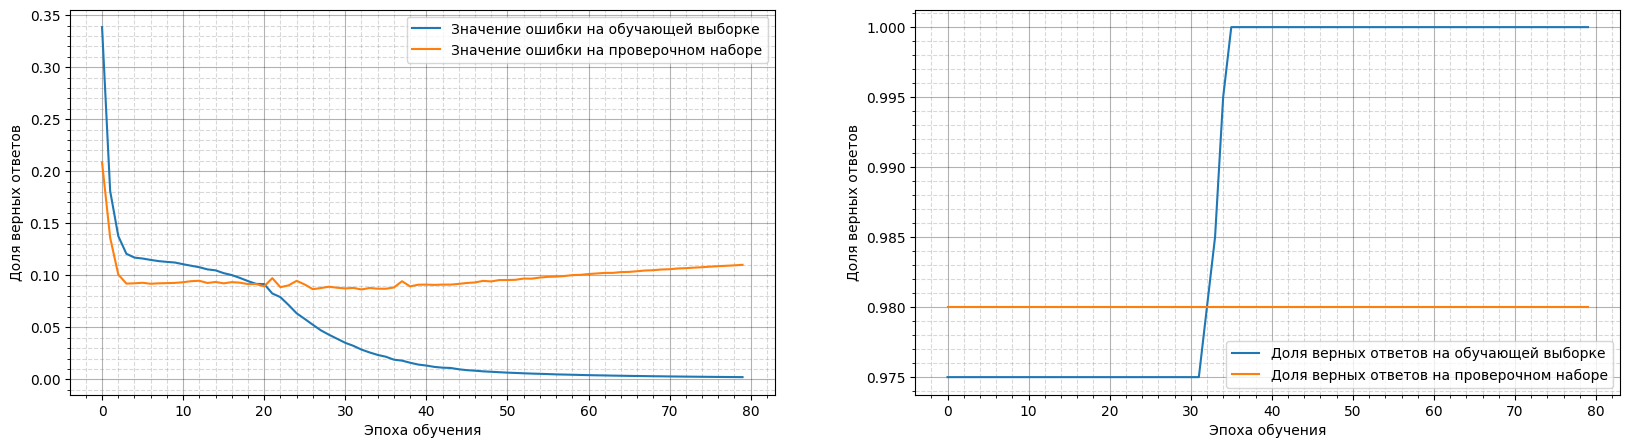

2/2 [==============================] - 0s 13ms/step - loss: 0.2098 - accuracy: 0.9524
Процент верных ответов на тестовых данных: 95.0 %


In [ ]:
model_cat = Sequential()
model_cat.add(Dense(20, input_dim=x_train_cat.shape[1], activation='relu'))
model_cat.add(Dense(20))
model_cat.add(Activation("sigmoid"))
model_cat.add(Dense(1, activation="sigmoid"))

# Компиляция и возврат модели
model_cat.compile(loss="binary_crossentropy",
                optimizer=Adam(learning_rate=0.001),
                metrics=["accuracy"])

history_cat = model_cat.fit(x_train_cat, y_train_cat, batch_size=8, epochs=80, validation_split=0.2, verbose=1)

plot_cat = func_plot(history_cat)

scores_cat = model_cat.evaluate(x_test_cat,
                          y_test_cat,
                          verbose=1
                          )

print("Процент верных ответов на тестовых данных:", round(scores_cat[1], 2) * 100, "%")

2/2 [==============================] - 0s 10ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 0.83
F1 score: 0.91
Accuracy: 0.95
Precision: 0.00
Recall: 0.00
F1 score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


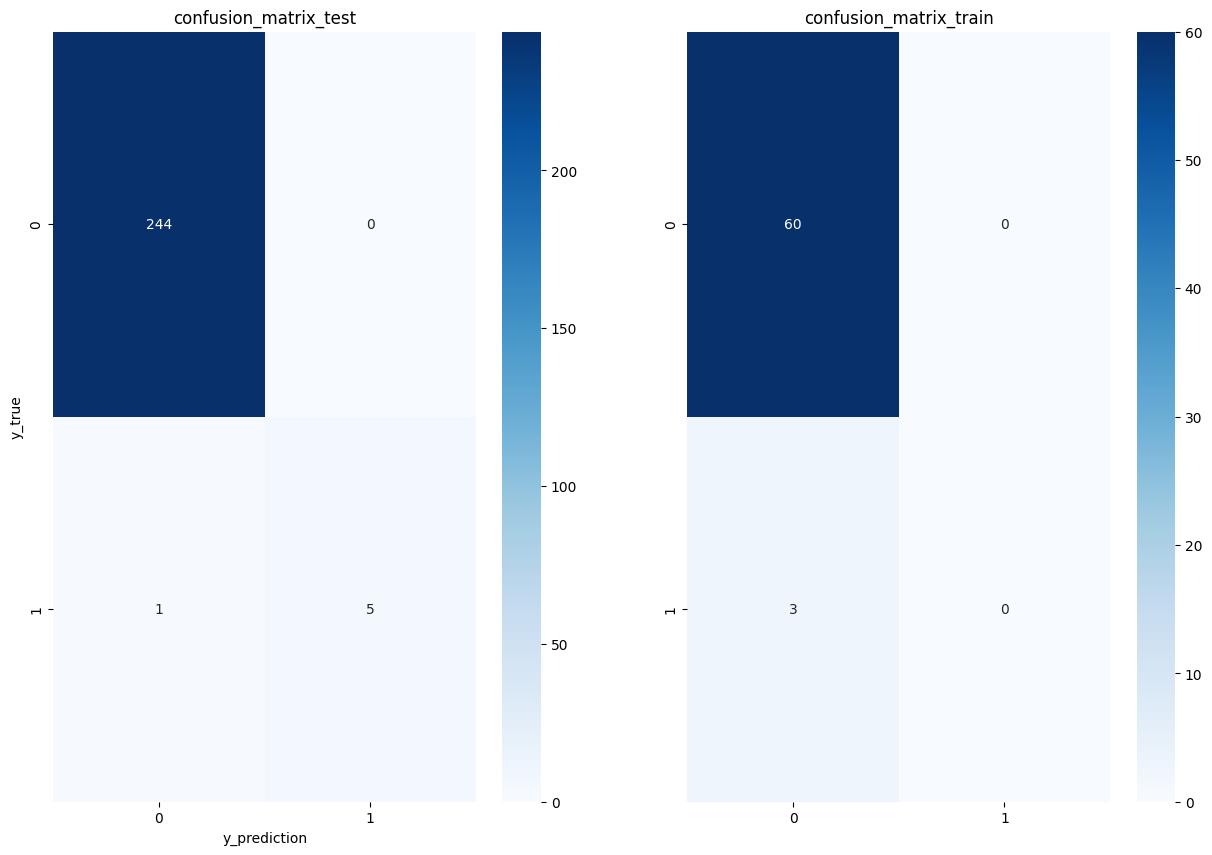

In [ ]:
# Вывод результатов оценки работы модели на тестовых данных

# Вычисление предсказания сети
y_predict_train_cat = model_cat.predict(x_train_cat)
y_predict_test_cat = model_cat.predict(x_test_cat)

# Матрица ошибок классификатора
confusion_matrix_train_cat = metrics.confusion_matrix(y_train_cat, y_predict_train_cat.round())
confusion_matrix_test_cat = metrics.confusion_matrix(y_test_cat, y_predict_test_cat.round())

# Отрисовка матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize = (15, 10)) # фигура + 2 координатные плоскости

# Тепловая карта для первой матрицы ошибок
sns.heatmap(confusion_matrix_train_cat, annot = True, fmt = '', ax = axes[0], cmap = 'Blues')
axes[1].set_title('confusion_matrix_train')
axes[1].set_xlabel('y_prediction')
axes[1].set_ylabel('y_true')

# Тепловая карта для второй матрицы ошибок
sns.heatmap(confusion_matrix_test_cat, annot = True, fmt = '', ax = axes[1], cmap = 'Blues')
axes[0].set_title('confusion_matrix_test')
axes[0].set_xlabel('y_prediction')
axes[0].set_ylabel('y_true')

# Вывод текстом
print(f'Accuracy: {metrics.accuracy_score(y_train_cat, y_predict_train_cat.round()):.2f}')
#Рассчет precision
print(f'Precision: {metrics.precision_score(y_train_cat, y_predict_train_cat.round()):.2f}')
#Рассчет recall
print(f'Recall: {metrics.recall_score(y_train_cat, y_predict_train_cat.round()):.2f}')
#Рассчет F1
print(f'F1 score: {metrics.f1_score(y_train_cat, y_predict_train_cat.round()):.2f}')

print(f'Accuracy: {metrics.accuracy_score(y_test_cat, y_predict_test_cat.round()):.2f}')
print(f'Precision: {metrics.precision_score(y_test_cat, y_predict_test_cat.round()):.2f}')
print(f'Recall: {metrics.recall_score(y_test_cat, y_predict_test_cat.round()):.2f}')
print(f'F1 score: {metrics.f1_score(y_test_cat, y_predict_test_cat.round()):.2f}')


Результат тот же. Эффект переобучения, недостаточно положительных меток, датасет несбалансирован.

###**Собираем текстовые данные** (столбцы "Выполняемые задачи на прошлых местах работ", "Обо мне")

In [ ]:
# Обработка текстовых данных
def func_text1(df):
  spisok = []

  for i in range(len(df)):
    spisok_text = ""
    for val in range(len(df[i])):
      if df[i][val] != 0 and (val == 0 or val == 1):
        spisok_text += df[i][val] + ". "
    spisok.append(spisok_text)

  spisok = np.array(spisok)

  return spisok

# Вытаскиваются текстовые данные и выводится пример
spisok_words_cat = func_text1(data3_text.values)
print("spisok_words_cat[0]", spisok_words_cat[0])

tokenizer.fit_on_texts(spisok_words_cat) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items_cat = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра

#преобразовываем текст в последовательность индексов согласно частотному словарю
spisok_words_indexes_cat = tokenizer.texts_to_sequences(spisok_words_cat) #обучающие тесты в индексы

# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain_cat_text = tokenizer.sequences_to_matrix(spisok_words_indexes_cat) # Подаем в виде списка чтобы метод успешно сработал
print(xTrain_cat_text.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain_cat_text[0][0:100])

x_train_cat_text, x_test_cat_text, y_train_cat_text, y_test_cat_text = train_test_split(xTrain_cat_text, y_cat, test_size=0.2) # Делим на тренировочную и тестовую выборку для текстовых данных
#Выводим результирующие размеры таблиц
print('Train:', x_train_cat_text.shape, y_train_cat_text.shape)
print('Test:', x_test_cat_text.shape, y_test_cat_text.shape)

# Пример обработанных данных
n = 0
print("x_train_cat_text[n]", x_train_cat_text[n])
print("y_train_cat_text[n]", y_train_cat_text[n])

spisok_words_cat[0] Маркетинговые исследования. Исследование рынка; Исследование конкурентов; Исследование потребителей; Планирование рекламы.. Виды исследований: Опросы; Фокус-группы; Глубинные интервью; Эксперименты, полевые исследования.. Задачи в рамках исследования потребителей: Анализ потребительских трендов; Анализ обратной связи от клиентов; Сегментация аудитории; Составление портрета целевой аудитории.. Реклама у лидеров мнений. Организация и контроль взаимодействия с лидерами мнений (селебрити, блогеры).. Опыт организации коллабораций.. SMM и комьюнити-менеджмент. Планирование продвижения; Создание и контроль контента; Наполнение аккаунтов, сообществ; Модерирование и развитие аккаунтов, сообществ.. Социальные сети: Telegram.. Прямая реклама. Разработка программ лояльности.Составление и тестирование гипотез. Анализ конкурентов. Изучение потребностей потребителя ( касдев, проведения интервью) CJM Работа с UX/UR Визуализация данных. Бизнесмодель. Токономика проекта. Работа с док

Epoch 1/80
25/25 [==============================] - 1s 14ms/step - loss: 0.2757 - accuracy: 0.9650 - val_loss: 0.1570 - val_accuracy: 0.9800
Epoch 2/80
25/25 [==============================] - 0s 8ms/step - loss: 0.1636 - accuracy: 0.9650 - val_loss: 0.1241 - val_accuracy: 0.9800
Epoch 3/80
25/25 [==============================] - 0s 14ms/step - loss: 0.1350 - accuracy: 0.9650 - val_loss: 0.1147 - val_accuracy: 0.9800
Epoch 4/80
25/25 [==============================] - 0s 14ms/step - loss: 0.1124 - accuracy: 0.9650 - val_loss: 0.1068 - val_accuracy: 0.9800
Epoch 5/80
25/25 [==============================] - 0s 10ms/step - loss: 0.0980 - accuracy: 0.9650 - val_loss: 0.1034 - val_accuracy: 0.9800
Epoch 6/80
25/25 [==============================] - 0s 9ms/step - loss: 0.0907 - accuracy: 0.9650 - val_loss: 0.1019 - val_accuracy: 0.9800
Epoch 7/80
25/25 [==============================] - 0s 11ms/step - loss: 0.0855 - accuracy: 0.9650 - val_loss: 0.1014 - val_accuracy: 0.9800
Epoch 8/80
25/2

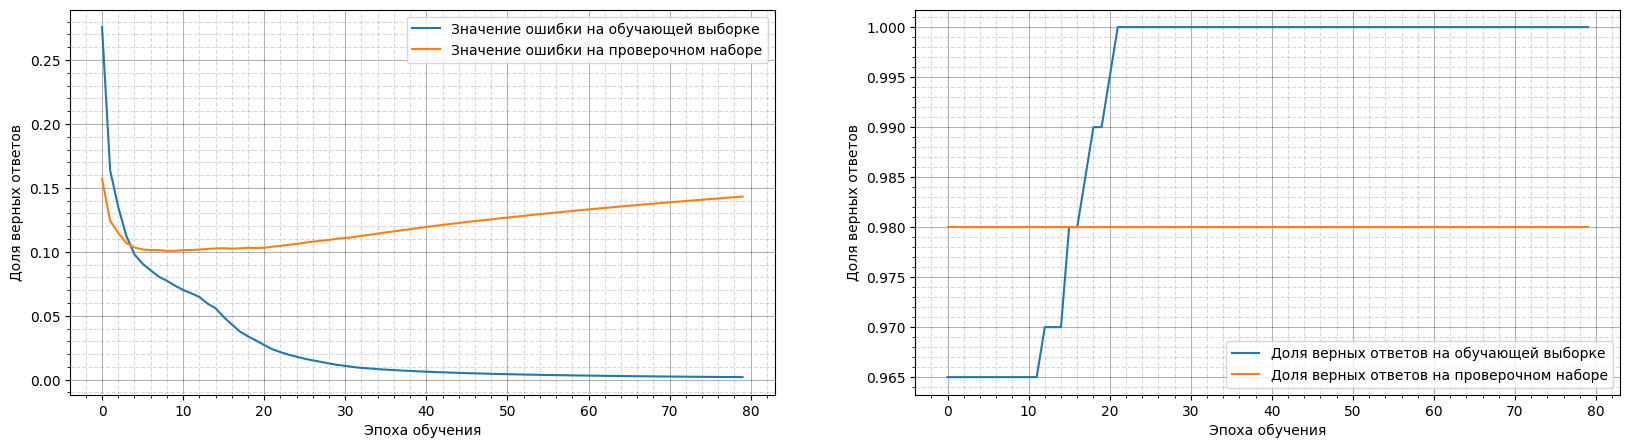

2/2 [==============================] - 0s 21ms/step - loss: 0.1010 - accuracy: 0.9841
Процент верных ответов на тестовых данных: 98.0 %


In [ ]:
model_cat_text = Sequential()

model_cat_text.add(Dense(20, input_dim=x_train_cat_text.shape[1], activation='relu'))

model_cat_text.add(Dense(20))
model_cat_text.add(Activation('sigmoid'))
model_cat_text.add(Dense(1, activation='sigmoid'))

# Компиляция и возврат модели
model_cat_text.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

history_cat_text = model_cat_text.fit(x_train_cat_text,    # Обучающая выборка параметров
        y_train_cat_text,               # Обучающая выборка меток класса
        batch_size=8,          # Размер батча (пакета)
        epochs=80,            # Количество эпох обучения
        validation_split=0.2,  # Доля проверочной выборки
        verbose=1)             # Отображение хода обучения

func_plot(history_cat_text)

scores_cat_text = model_cat_text.evaluate(x_test_cat_text,
                          y_test_cat_text,
                          verbose=1
                          )

print("Процент верных ответов на тестовых данных:", round(scores_cat_text[1], 2) * 100, "%")


2/2 [==============================] - 0s 8ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 0.88
F1 score: 0.93
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
F1 score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


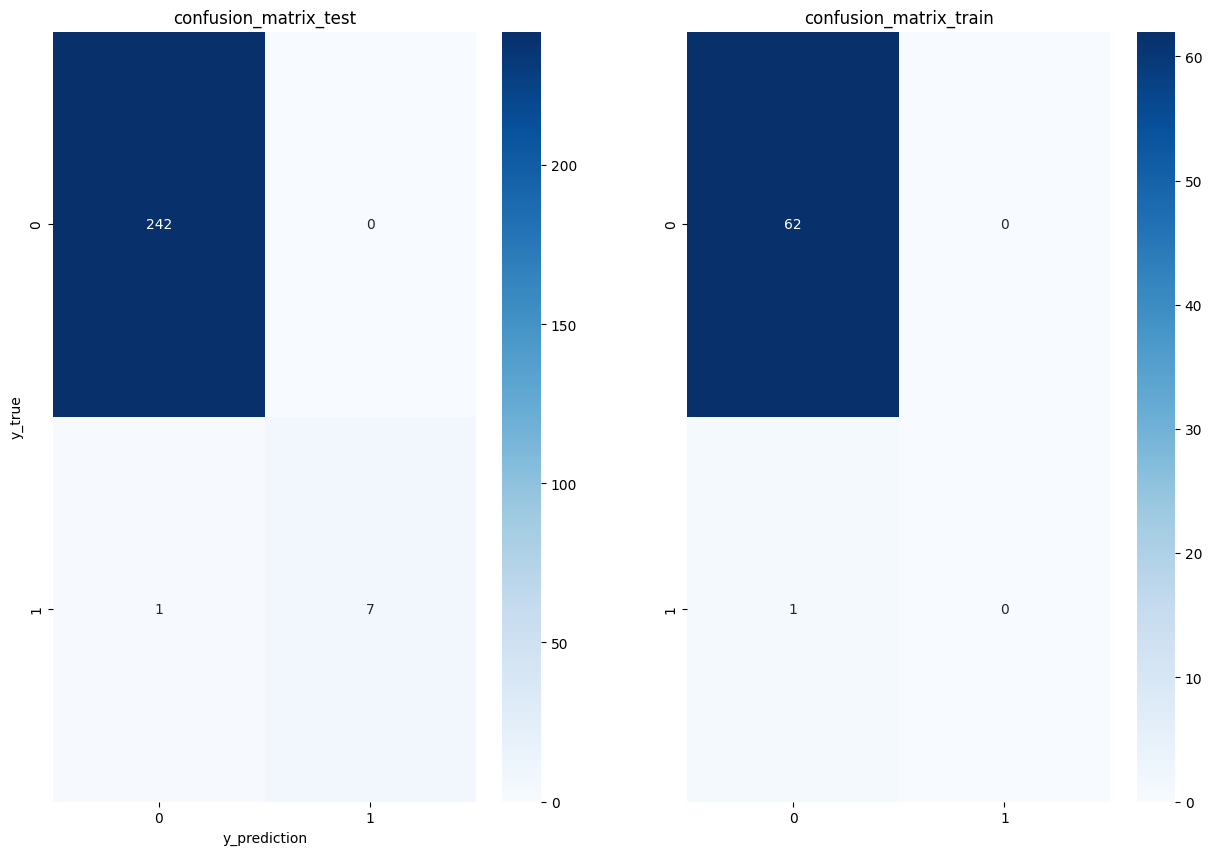

In [ ]:
# Вывод результатов оценки работы модели на тестовых данных

# Вычисление предсказания сети
y_predict_train_cat_text = model_cat_text.predict(x_train_cat_text)
y_predict_test_cat_text = model_cat_text.predict(x_test_cat_text)

# Матрица ошибок классификатора
confusion_matrix_train_cat_text = metrics.confusion_matrix(y_train_cat_text, y_predict_train_cat_text.round())
confusion_matrix_test_cat_text = metrics.confusion_matrix(y_test_cat_text, y_predict_test_cat_text.round())

# Отрисовка матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize = (15, 10)) # фигура + 2 координатные плоскости

# Тепловая карта для первой матрицы ошибок
sns.heatmap(confusion_matrix_train_cat_text, annot = True, fmt = '', ax = axes[0], cmap = 'Blues')
axes[1].set_title('confusion_matrix_train')
axes[1].set_xlabel('y_prediction')
axes[1].set_ylabel('y_true')

# Тепловая карта для второй матрицы ошибок
sns.heatmap(confusion_matrix_test_cat_text, annot = True, fmt = '', ax = axes[1], cmap = 'Blues')
axes[0].set_title('confusion_matrix_test')
axes[0].set_xlabel('y_prediction')
axes[0].set_ylabel('y_true')

# Вывод текстом
print(f'Accuracy: {metrics.accuracy_score(y_train_cat_text, y_predict_train_cat_text.round()):.2f}')
#Рассчет precision
print(f'Precision: {metrics.precision_score(y_train_cat_text, y_predict_train_cat_text.round()):.2f}')
#Рассчет recall
print(f'Recall: {metrics.recall_score(y_train_cat_text, y_predict_train_cat_text.round()):.2f}')
#Рассчет F1
print(f'F1 score: {metrics.f1_score(y_train_cat_text, y_predict_train_cat_text.round()):.2f}')

print(f'Accuracy: {metrics.accuracy_score(y_test_cat_text, y_predict_test_cat_text.round()):.2f}')
print(f'Precision: {metrics.precision_score(y_test_cat_text, y_predict_test_cat_text.round()):.2f}')
print(f'Recall: {metrics.recall_score(y_test_cat_text, y_predict_test_cat_text.round()):.2f}')
print(f'F1 score: {metrics.f1_score(y_test_cat_text, y_predict_test_cat_text.round()):.2f}')


###**Составная НС** (категориальная + текстовая с 2 столбцов)

Epoch 1/150
8/8 [==============================] - 4s 290ms/step - loss: 0.3861 - accuracy: 0.9760 - val_loss: 0.7345 - val_accuracy: 0.9524
Epoch 2/150
8/8 [==============================] - 2s 288ms/step - loss: 0.3736 - accuracy: 0.9760 - val_loss: 0.7345 - val_accuracy: 0.9524
Epoch 3/150
8/8 [==============================] - 2s 241ms/step - loss: 0.3702 - accuracy: 0.9760 - val_loss: 0.7345 - val_accuracy: 0.9524
Epoch 4/150
8/8 [==============================] - 2s 227ms/step - loss: 0.3709 - accuracy: 0.9760 - val_loss: 0.7345 - val_accuracy: 0.9524
Epoch 5/150
8/8 [==============================] - 2s 227ms/step - loss: 0.3702 - accuracy: 0.9760 - val_loss: 0.7345 - val_accuracy: 0.9524
Epoch 6/150
8/8 [==============================] - 1s 177ms/step - loss: 0.3702 - accuracy: 0.9760 - val_loss: 0.7345 - val_accuracy: 0.9524
Epoch 7/150
8/8 [==============================] - 1s 179ms/step - loss: 0.3702 - accuracy: 0.9760 - val_loss: 0.7345 - val_accuracy: 0.9524
Epoch 8/150
8

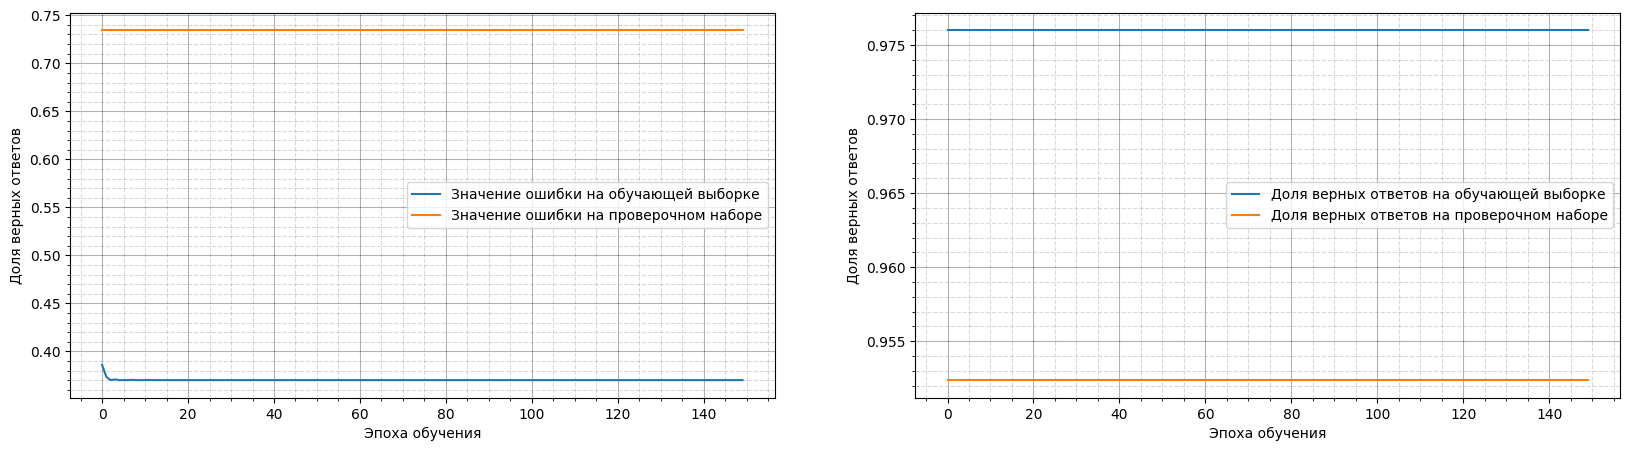

8/8 [==============================] - 1s 39ms/step


NameError: ignored

In [ ]:
input1_cat = Input((x_train_cat.shape[1],))
input2_cat = Input((x_train_cat_text.shape[1],))

x1_cat = BatchNormalization()(input1_cat) # Создаем ветку х1
x1_cat = Dropout(0.5)(x1_cat)
x1_cat = Dense(25, activation="relu")(x1_cat)
x1_cat = Dense(5, activation="relu")(x1_cat)
x1_cat = Dense(5, activation = "relu")(x1_cat)

x2_cat = BatchNormalization()(input2_cat) # Создаем ветку х2
x2_cat = Dense(1000, activation="relu")(input2_cat)
x2_cat = Dense(100, activation="tanh")(x2_cat)
x2_cat = Dense(20, activation = "elu")(x2_cat)

x_cat = concatenate([x1_cat, x2_cat]) # Объединяем все ветки

x_cat = Dense(15, activation='relu')(x_cat)
x_cat = Dropout(0.5)(x_cat)
x_cat = Dense(1, activation='relu')(x_cat) # Финальный нейрон, делает регрессию

model_compose_cat = Model((input1_cat, input2_cat), x_cat) # В Model загружаем стартовые и последнюю точки

model_compose_cat.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_compose_cat = model_compose_cat.fit([x_train_cat, x_train_cat_text],
                    y_train_cat,
                    epochs= 150,
                    validation_data=([x_test_cat, x_test_cat_text],
                    y_test_cat),
                    verbose=1, shuffle=True)

plot_compose_cat = func_plot(history_compose_cat)


2/2 [==============================] - 0s 80ms/step
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
F1 score: 0.00
Accuracy: 0.95
Precision: 0.00
Recall: 0.00
F1 score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


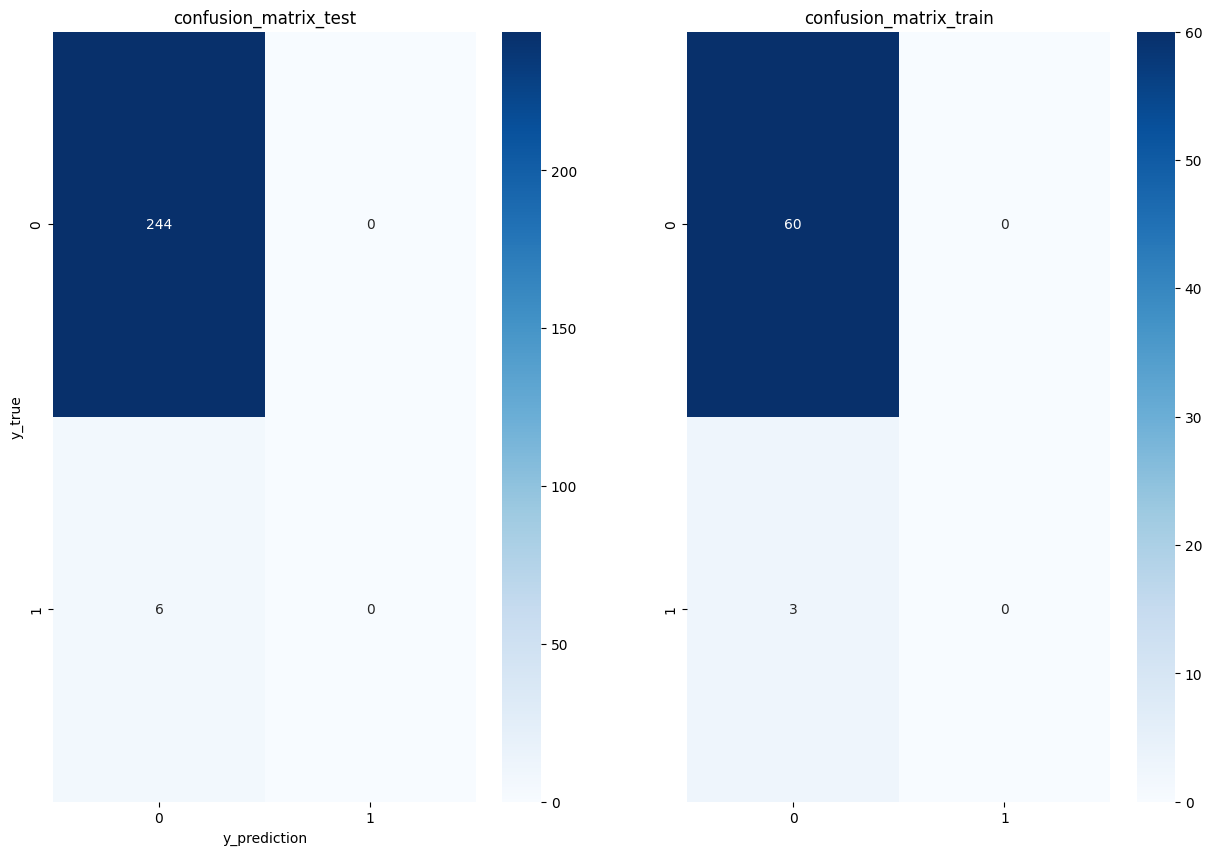

In [ ]:
# Вывод результатов оценки работы модели на тестовых данных
y_predict_train_compose_cat = model_compose_cat.predict([x_train_cat, x_train_cat_text])
y_predict_test_compose_cat = model_compose_cat.predict([x_test_cat, x_test_cat_text])

# Матрица ошибок классификатора
confusion_matrix_train_compose_cat = metrics.confusion_matrix(y_train_cat, y_predict_train_compose_cat.round())
confusion_matrix_test_compose_cat = metrics.confusion_matrix(y_test_cat, y_predict_test_compose_cat.round())

# Отрисовка матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize = (15, 10)) # фигура + 2 координатные плоскости

# Тепловая карта для первой матрицы ошибок
sns.heatmap(confusion_matrix_train_compose_cat, annot = True, fmt = '', ax = axes[0], cmap = 'Blues')
axes[1].set_title('confusion_matrix_train')
axes[1].set_xlabel('y_prediction')
axes[1].set_ylabel('y_true')

# Тепловая карта для второй матрицы ошибок
sns.heatmap(confusion_matrix_test_compose_cat, annot = True, fmt = '', ax = axes[1], cmap = 'Blues')
axes[0].set_title('confusion_matrix_test')
axes[0].set_xlabel('y_prediction')
axes[0].set_ylabel('y_true')

# Вывод текстом
print(f'Accuracy: {metrics.accuracy_score(y_train_cat, y_predict_train_compose_cat.round()):.2f}')
#Рассчет precision
print(f'Precision: {metrics.precision_score(y_train_cat, y_predict_train_compose_cat.round()):.2f}')
#Рассчет recall
print(f'Recall: {metrics.recall_score(y_train_cat, y_predict_train_compose_cat.round()):.2f}')
#Рассчет F1
print(f'F1 score: {metrics.f1_score(y_train_cat, y_predict_train_compose_cat.round()):.2f}')

print(f'Accuracy: {metrics.accuracy_score(y_test_cat, y_predict_test_compose_cat.round()):.2f}')
print(f'Precision: {metrics.precision_score(y_test_cat, y_predict_test_compose_cat.round()):.2f}')
print(f'Recall: {metrics.recall_score(y_test_cat, y_predict_test_compose_cat.round()):.2f}')
print(f'F1 score: {metrics.f1_score(y_test_cat, y_predict_test_compose_cat.round()):.2f}')

###**Заключение**

**Выводы**, к которым я пришла в результате работы в этом ноутбуке на данном датасете:

1) Датасет ненормирован

2) Датасет маленький для нормального обучения НС

3) Слишком мало положительных меток

4) НС хорошо обучается определять в результате первых трех пунктов отрицательный результат и практически совсем не определяет положительные метки

В общем по проекте точность рекомендации на тестовой выборке не менее 97%. Да, он хорошо определяет отрицательные метки, но не указывает правильно положительные. Возникло это из-за сильнейшего перекоса между количеством положительных и отрицательных меток и небольшого количество положительных меток вообще.


Какие варианты при обучении НС я использовала:

1) По всему изначальному датасету взяты простые табличные данные (кроме колонок Последнее/нынешное место работы, Последняя/нынешняя должность, Выполняемые задачи на прошлых местах работ, Обо мне, Ключевые навыки)

2) По всему изначальному датасету взяты только текстовые колонки (Последнее/нынешное место работы, Последняя/нынешняя должность, Выполняемые задачи на прошлых местах работ, Обо мне, Ключевые навыки). Использовался токенайзер кераса.

3) По всему изначальному датасету взяты 1 и 2 нейронка.


Потом выделила датасет только по 2 вакансиям, по которым было наибольшее количество положительных меток: "Growth Product Manager" и "HR-специалист"

4) По 2 вакансиям взяты простые табличные данные (кроме колонок Последнее/нынешное место работы, Последняя/нынешняя должность, Выполняемые задачи на прошлых местах работ, Обо мне, Ключевые навыки)

5) По 2 вакансиям взяты только текстовые колонки (Последнее/нынешное место работы, Последняя/нынешняя должность, Выполняемые задачи на прошлых местах работ, Обо мне, Ключевые навыки). Использовался токенайзер кераса.

6) По 2 вакансиям взяты 4 и 5 нейронка.


Потом я решила попробовать категориализировать датасет (кроме колонок "Выполняемые задачи на прошлых местах работ", "Обо мне". По ним попробовала сделать отдельную НС)

7) По 2 вакансиям взяты все колонки (кроме "Выполняемые задачи на прошлых местах работ", "Обо мне")

8) По 2 вакансиям взяты колонки "Выполняемые задачи на прошлых местах работ", "Обо мне". Использовался токенайзер кераса.

9) По 2 вакансиям взяты 7 и 8 нейронка.


На графиках большинства обученных НС ясно видно эффект переобучения, что подтверждает то, что датасет ненормирован (маленькая, разбалансированная база).
Количество эпох при тестированиях на составных НС использовалась 80 или 150, на остальных 50 или 80. В колабе оставила последний вариант теста, так как и на небольшом количестве эпох картина была такой же.